In [1]:
# Load packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from category_encoders import TargetEncoder
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import optuna
import warnings

In [2]:
# Load data
train = pd.read_csv('C:/Users/Neil/KaggleHousePrices/train.csv')
test = pd.read_csv('C:/Users/Neil/KaggleHousePrices/test.csv')

In [3]:
# Adjust settings to display all columns in tables
pd.set_option('display.max_columns',  None)
pd.set_option('display.max_rows',  None)
warnings.filterwarnings('ignore')

In [4]:
# Let's take a look at the data
train.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities LotConfig LandSlope Neighborhood Condition1  \
0         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
1         Lvl    AllPub       FR2       Gtl      Veenker      Feedr   
2         Lvl    AllPub    Inside       Gtl      CollgCr       Norm   
3         Lvl    AllPub    Corner       Gtl      Crawfor       Norm   
4         Lvl    AllPub       FR2       Gtl      NoRidge       Norm   

  Condition2 BldgType HouseStyle  OverallQual  OverallCond  YearBuilt  \
0       Norm     1Fam     2Story            7            5       2003   
1       Norm     1Fam     1Story            6            8       1976   
2       Norm     1Fam     2Story            7            5       2001   
3       Norm     1Fam     2Story            7            5       1915   
4       Norm     1Fam     2Story            8            5       2000   

   YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd MasVnrType  \
0          2003     Gable  CompShg     VinylSd     VinylSd    BrkFace   
1          1976     Gable  CompShg     MetalSd     MetalSd        NaN   
2          2002     Gable  CompShg     VinylSd     VinylSd    BrkFace   
3          1970     Gable  CompShg     Wd Sdng     Wd Shng        NaN   
4          2000     Gable  CompShg     VinylSd     VinylSd    BrkFace   

   MasVnrArea ExterQual ExterCond Foundation BsmtQual BsmtCond BsmtExposure  \
0       196.0        Gd        TA      PConc       Gd       TA           No   
1         0.0        TA        TA     CBlock       Gd       TA           Gd   
2       162.0        Gd        TA      PConc       Gd       TA           Mn   
3         0.0        TA        TA     BrkTil       TA       Gd           No   
4       350.0        Gd        TA      PConc       Gd       TA           Av   

  BsmtFinType1  BsmtFinSF1 BsmtFinType2  BsmtFinSF2  BsmtUnfSF  TotalBsmtSF  \
0          GLQ         706          Unf           0        150          856   
1          ALQ         978          Unf           0        284         1262   
2          GLQ         486          Unf           0        434          920   
3          ALQ         216          Unf           0        540          756   
4          GLQ         655          Unf           0        490         1145   

  Heating HeatingQC CentralAir Electrical  1stFlrSF  2ndFlrSF  LowQualFinSF  \
0    GasA        Ex          Y      SBrkr       856       854             0   
1    GasA        Ex          Y      SBrkr      1262         0             0   
2    GasA        Ex          Y      SBrkr       920       866             0   
3    GasA        Gd          Y      SBrkr       961       756             0   
4    GasA        Ex          Y      SBrkr      1145      1053             0   

   GrLivArea  BsmtFullBath  BsmtHalfBath  FullBath  HalfBath  BedroomAbvGr  \
0       1710             1             0         2         1             3   
1       1262             0             1         2         0             3   
2       1786             1             0         2         1             3   
3       1717             1             0         1         0             3   
4       2198             1             0         2         1             4   

   KitchenAbvGr KitchenQual  TotRmsAbvGrd Functional  Fireplaces FireplaceQu  \
0             1          Gd             8        Typ           0         NaN   
1             1          TA             6        Typ           1          TA   
2             1          Gd             6        Typ           1          TA   
3             1          Gd            

We can see that a lot of the data is categorical and describes the properties of the house/lot.

In [5]:
# Let's look at the summary statistics
train.describe(include='all')

Id   MSSubClass MSZoning  LotFrontage        LotArea Street  \
count   1460.000000  1460.000000     1460  1201.000000    1460.000000   1460   
unique          NaN          NaN        5          NaN            NaN      2   
top             NaN          NaN       RL          NaN            NaN   Pave   
freq            NaN          NaN     1151          NaN            NaN   1454   
mean     730.500000    56.897260      NaN    70.049958   10516.828082    NaN   
std      421.610009    42.300571      NaN    24.284752    9981.264932    NaN   
min        1.000000    20.000000      NaN    21.000000    1300.000000    NaN   
25%      365.750000    20.000000      NaN    59.000000    7553.500000    NaN   
50%      730.500000    50.000000      NaN    69.000000    9478.500000    NaN   
75%     1095.250000    70.000000      NaN    80.000000   11601.500000    NaN   
max     1460.000000   190.000000      NaN   313.000000  215245.000000    NaN   

       Alley LotShape LandContour Utilities LotConfig LandSlope Neighborhood  \
count     91     1460        1460      1460      1460      1460         1460   
unique     2        4           4         2         5         3           25   
top     Grvl      Reg         Lvl    AllPub    Inside       Gtl        NAmes   
freq      50      925        1311      1459      1052      1382          225   
mean     NaN      NaN         NaN       NaN       NaN       NaN          NaN   
std      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
min      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
25%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
50%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
75%      NaN      NaN         NaN       NaN       NaN       NaN          NaN   
max      NaN      NaN         NaN       NaN       NaN       NaN          NaN   

       Condition1 Condition2 BldgType HouseStyle  OverallQual  OverallCond  \
count        1460       1460     1460       1460  1460.000000  1460.000000   
unique          9          8        5          8          NaN          NaN   
top          Norm       Norm     1Fam     1Story          NaN          NaN   
freq         1260       1445     1220        726          NaN          NaN   
mean          NaN        NaN      NaN        NaN     6.099315     5.575342   
std           NaN        NaN      NaN        NaN     1.382997     1.112799   
min           NaN        NaN      NaN        NaN     1.000000     1.000000   
25%           NaN        NaN      NaN        NaN     5.000000     5.000000   
50%           NaN        NaN      NaN        NaN     6.000000     5.000000   
75%           NaN        NaN      NaN        NaN     7.000000     6.000000   
max           NaN        NaN      NaN        NaN    10.000000     9.000000   

          YearBuilt  YearRemodAdd RoofStyle RoofMatl Exterior1st Exterior2nd  \
count   1460.000000   1460.000000      1460     1460        1460        1460   
unique          NaN           NaN         6        8          15          16   
top             NaN           NaN     Gable  CompShg     VinylSd     VinylSd   
freq            NaN           NaN      1141     1434         515         504   
mean    1971.267808   1984.865753       NaN      NaN         NaN         NaN   
std       30.202904     20.645407       NaN      NaN         NaN         NaN   
min     1872.000000   1950.000000       NaN      NaN         NaN         NaN   
25%     1954.000000   1967.000000       NaN      NaN         NaN         NaN   
50%     1973.000000   1994.000000       NaN      NaN         NaN         NaN   
75%     2000.000000   2004.000000       NaN      NaN         NaN         NaN   
max     2010.000000   2010.000000       NaN      NaN         NaN         NaN   

       MasVnrType   MasVnrArea ExterQual ExterCond Foundation BsmtQual  \
count         588  1452.000000      1460      1460       1460     1423   
unique          3          NaN         4         

In [6]:
# Let's look at the datatypes and missing values
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Only 3 different datatypes are present, integer, floating point numbers, and objects. There are a few columns that are missing a lot of values. Let's calculate the percent of missing values for each column.

In [7]:
# Calculate the percentage of missing values in each column
missing_percentage = train.isnull().sum() * 100 / len(train)

# Create a DataFrame to display results in a table format
missing_percentage_df = pd.DataFrame(missing_percentage, columns=['Missing_Percentage'])

# Sort the values and display only those columns with missing values
missing_percentage_df.sort_values("Missing_Percentage", ascending=False).query('Missing_Percentage != 0')

Missing_Percentage
PoolQC                 99.520548
MiscFeature            96.301370
Alley                  93.767123
Fence                  80.753425
MasVnrType             59.726027
FireplaceQu            47.260274
LotFrontage            17.739726
GarageYrBlt             5.547945
GarageCond              5.547945
GarageType              5.547945
GarageFinish            5.547945
GarageQual              5.547945
BsmtFinType2            2.602740
BsmtExposure            2.602740
BsmtQual                2.534247
BsmtCond                2.534247
BsmtFinType1            2.534247
MasVnrArea              0.547945
Electrical              0.068493

Only 19 columns have missing values and only 4 of those have greater than 80% missing values.

In [8]:
# Let's take a closer look at those 4 columns
train.PoolQC.value_counts()

PoolQC
Gd    3
Ex    2
Fa    2
Name: count, dtype: int64

Since only 7 houses list a pool quality, let's check to see if the other houses have a pool area listed, if not we'll fill in the missing values in PoolQC with NA.

In [9]:
# Check Pool Area
train.PoolArea.value_counts()

PoolArea
0      1453
512       1
648       1
576       1
555       1
480       1
519       1
738       1
Name: count, dtype: int64

In [10]:
# Check to see if the listed pool areas belong to pool QC
train.query('PoolQC.notnull()').PoolArea

197     512
810     648
1170    576
1182    555
1298    480
1386    519
1423    738
Name: PoolArea, dtype: int64

We get 7 houses with a Pool Area listed that match the houses with a PoolQC value, so let's assume the remaining properties do not have pools and fill in poolQC with NA.

In [11]:
# Replace missing values in PoolQC with NA
train.PoolQC.fillna('NA', inplace=True)
test.PoolQC.fillna('NA', inplace=True)

In [12]:
# Let's take a similar approach with MiscFeature
# Check what categories exist
train.MiscFeature.value_counts()

MiscFeature
Shed    49
Gar2     2
Othr     2
TenC     1
Name: count, dtype: int64

In [13]:
# Check MiscValue
train.MiscVal.value_counts()

MiscVal
0        1408
400        11
500         8
700         5
450         4
600         4
2000        4
1200        2
480         2
15500       1
800         1
350         1
3500        1
1300        1
54          1
620         1
560         1
1400        1
8300        1
1150        1
2500        1
Name: count, dtype: int64

In [14]:
# Knowing that MiscValue has a lot of values as 0, it's safe to assume any MiscFeature missing value is NA
train.MiscFeature.fillna('NA', inplace=True)
test.MiscFeature.fillna('NA', inplace=True)

In [15]:
# The last two do not have anything we can compare with
train.Alley.value_counts()

Alley
Grvl    50
Pave    41
Name: count, dtype: int64

In [16]:
train.Fence.value_counts()

Fence
MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: count, dtype: int64

We're going to drop those 2 columns as computing missing values with only 20% of the data is challenging without introducing bias.

We'll exclude PoolQC, PoolArea, MiscFeature, MiscValue, Alley, and Fence from modeling due to lack of data.

In [17]:
# Drop those six columns
train.drop(['PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal', 'Alley', 'Fence'], axis=1, inplace=True)
test.drop(['PoolQC', 'PoolArea', 'MiscFeature', 'MiscVal', 'Alley', 'Fence'], axis=1, inplace=True)

In [18]:
# Next let's tackle the others columns with missing values
train.FireplaceQu.value_counts().sum()

770

In [19]:
# Let's see how many houses have a fireplace listed
train.Fireplaces.value_counts()

Fireplaces
0    690
1    650
2    115
3      5
Name: count, dtype: int64

This shows that 770 houses have a fireplace quality listed and 770 houses have a fireplace. Thus we can conclude that the remaining 690 do not have a quality listed b/c they don't have a fireplace.

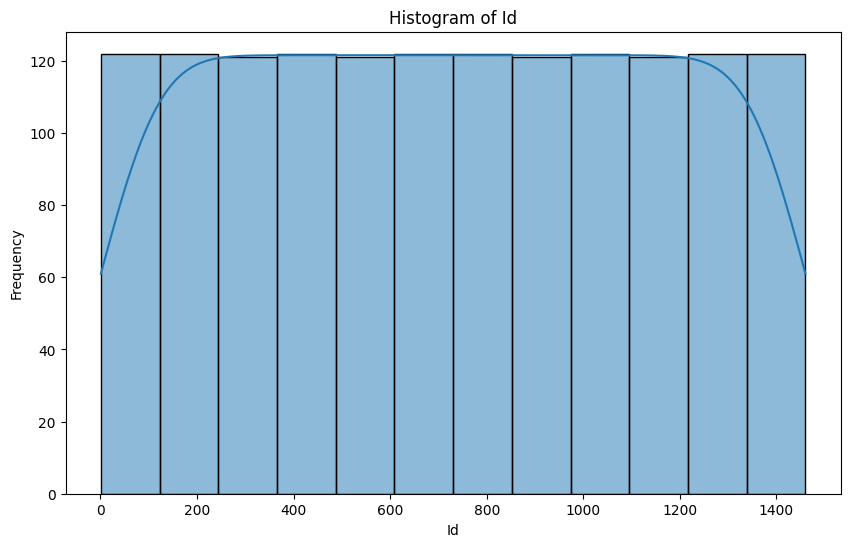

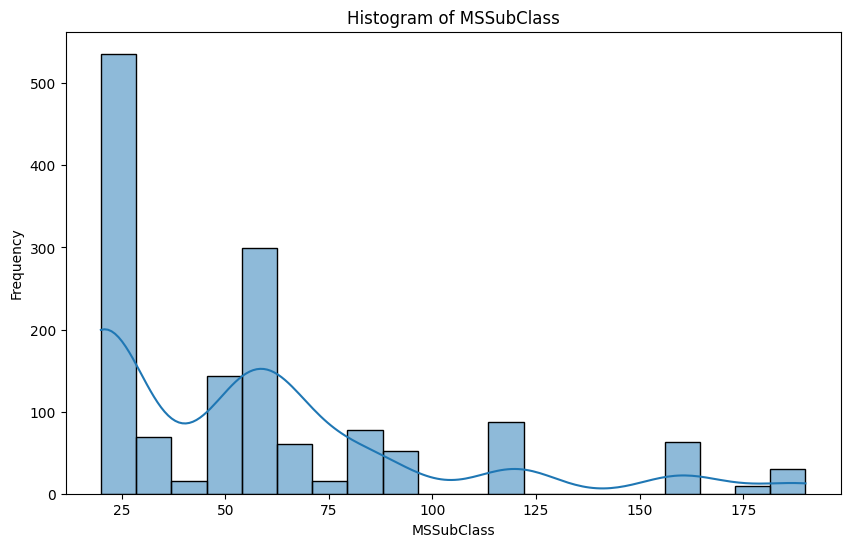

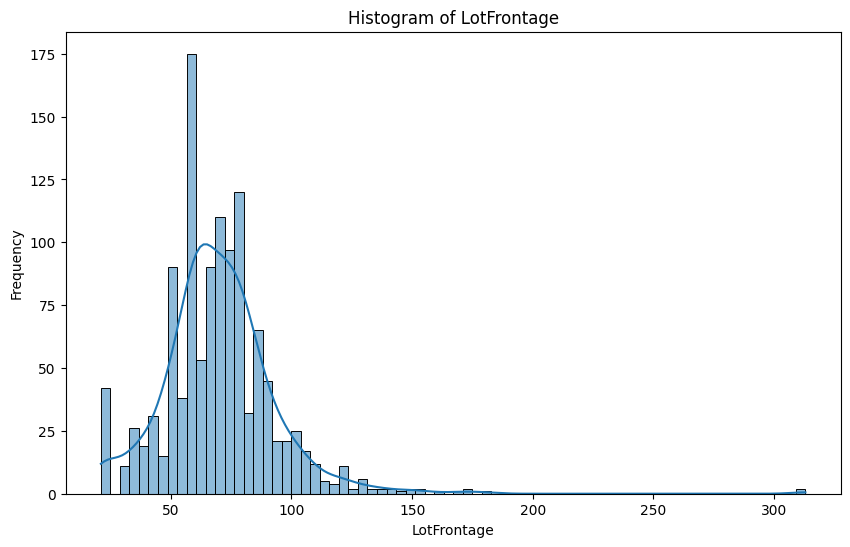

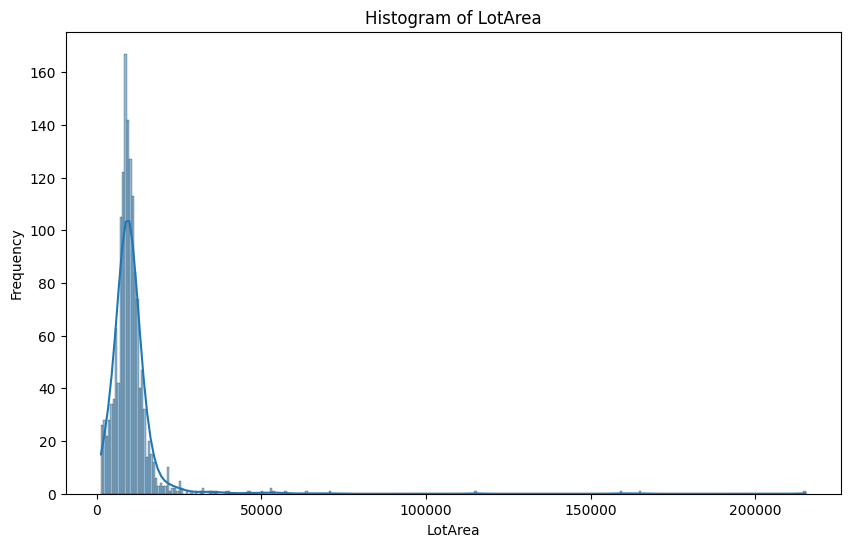

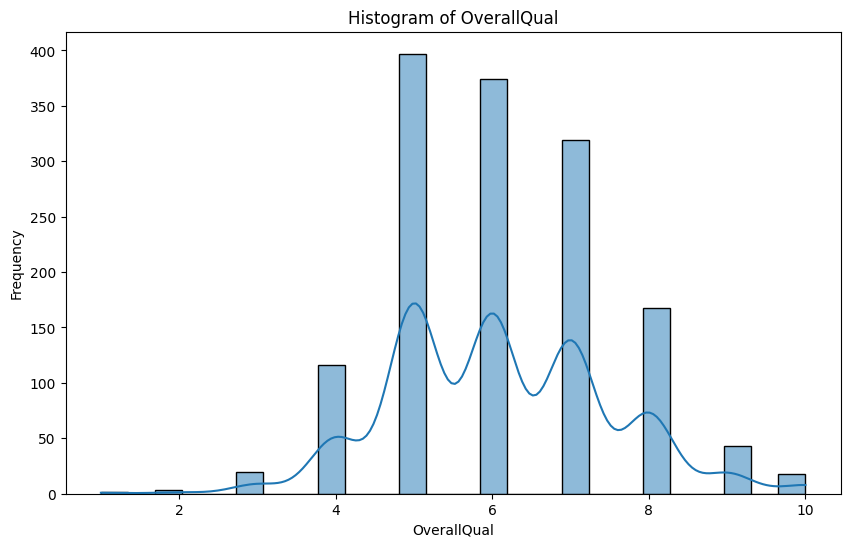

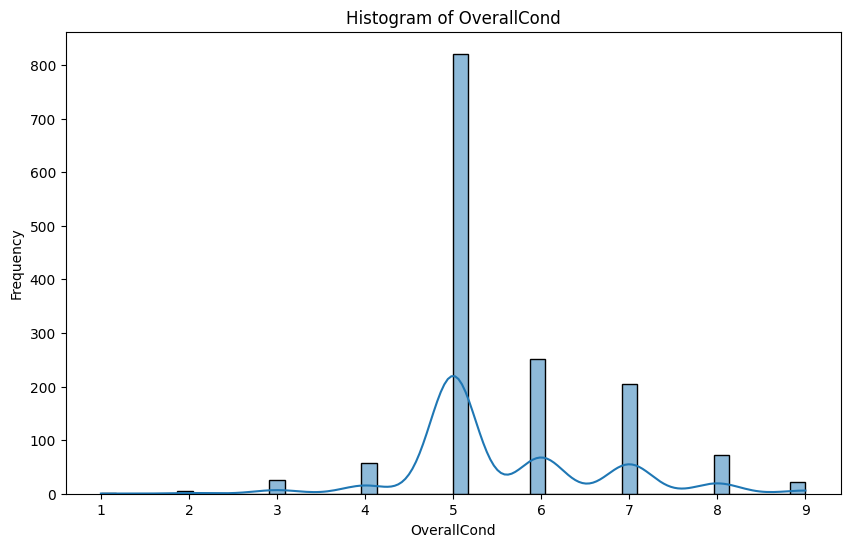

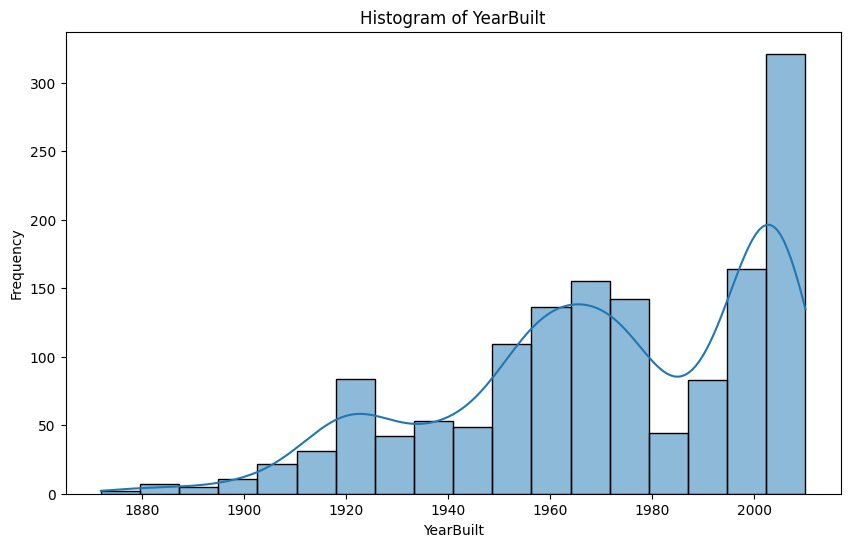

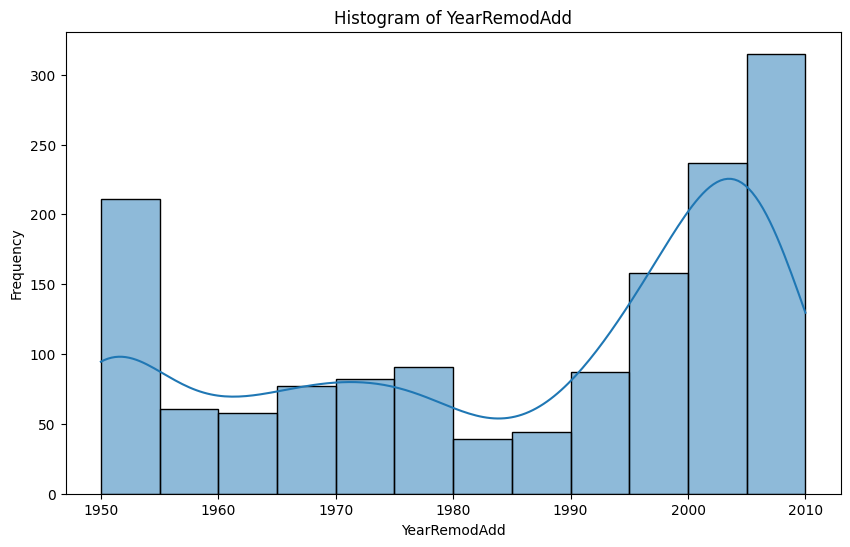

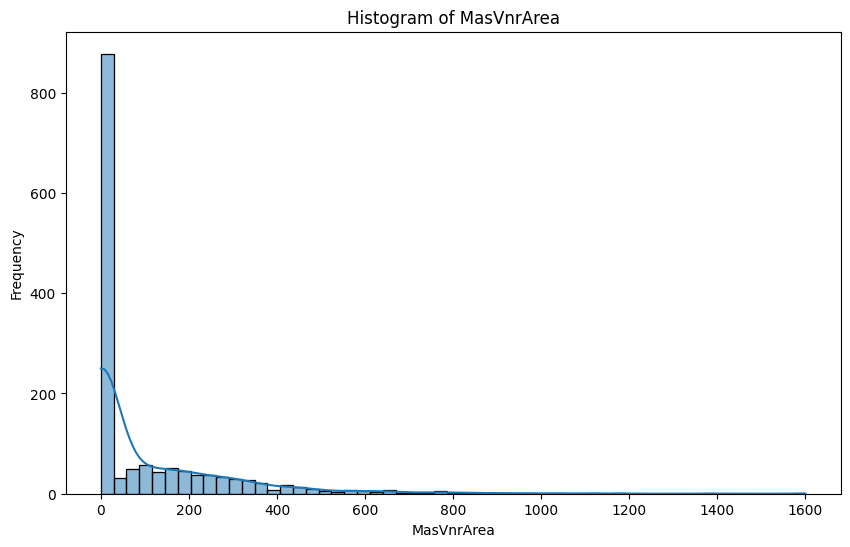

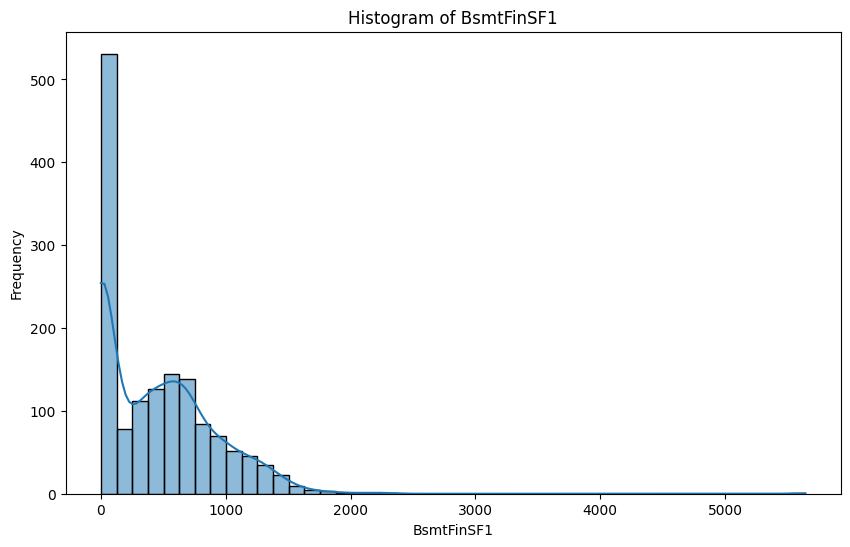

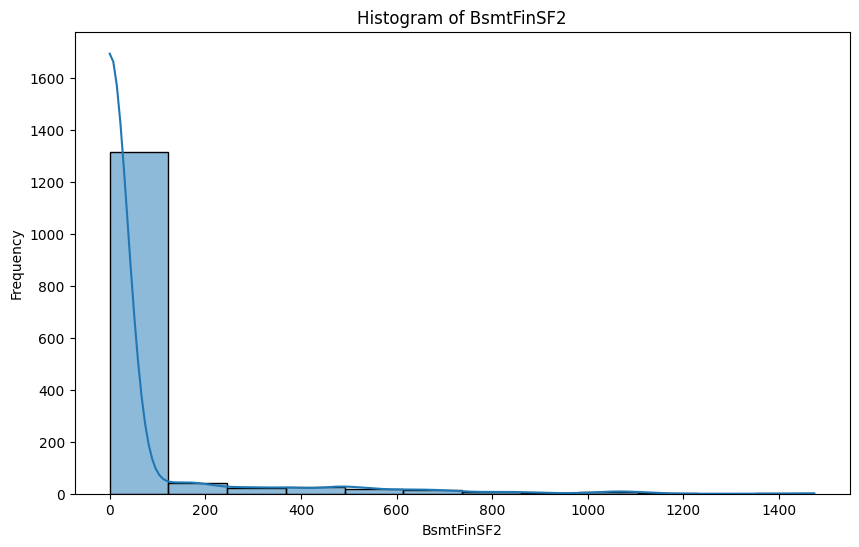

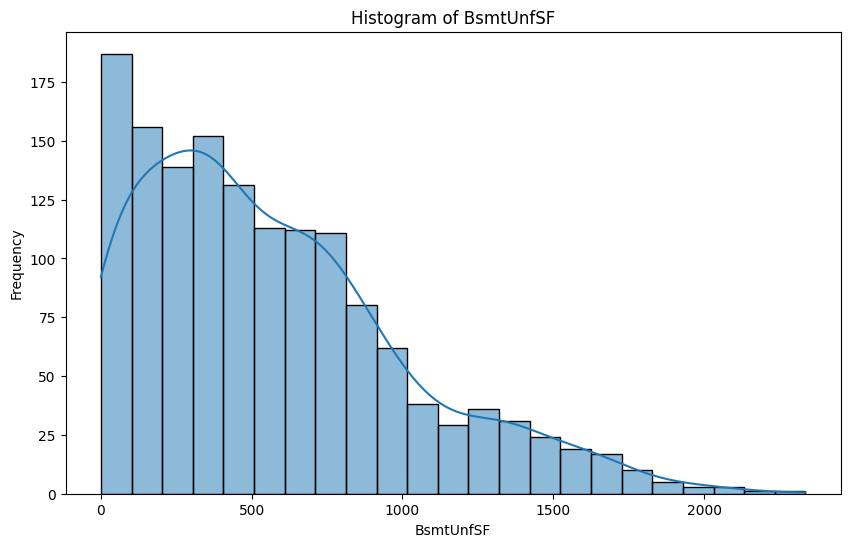

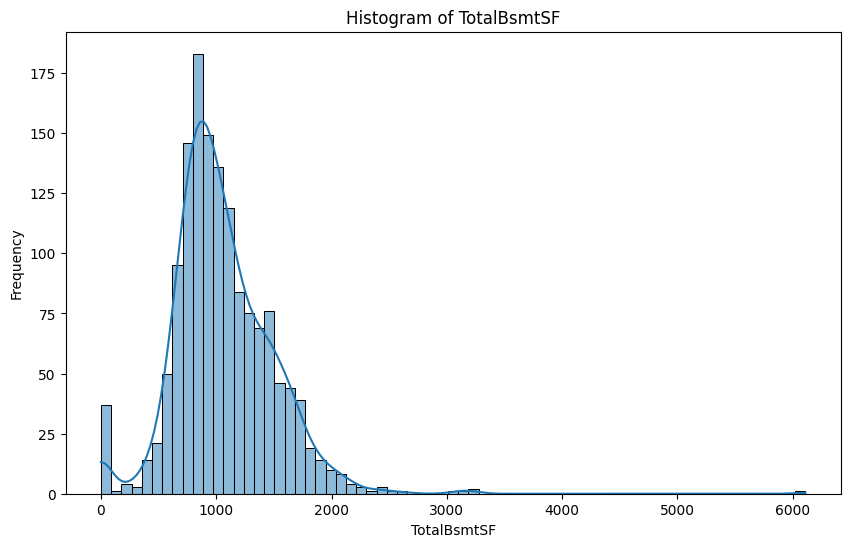

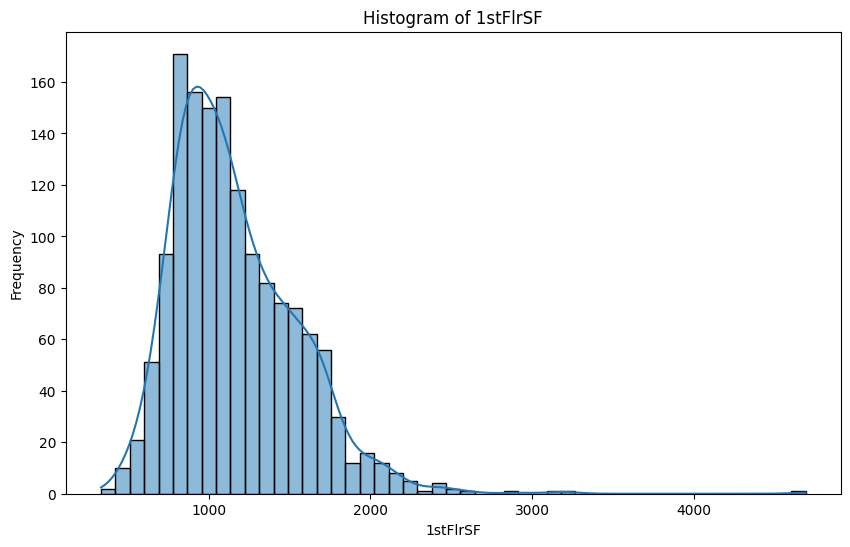

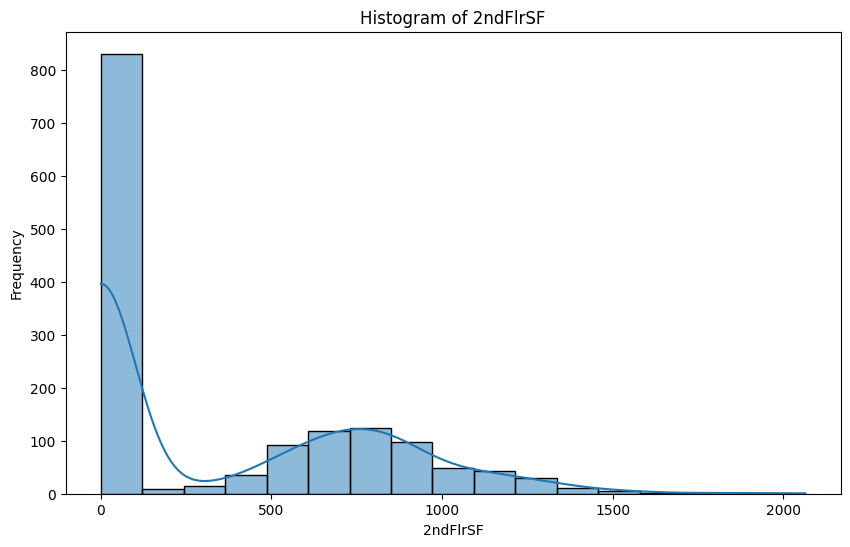

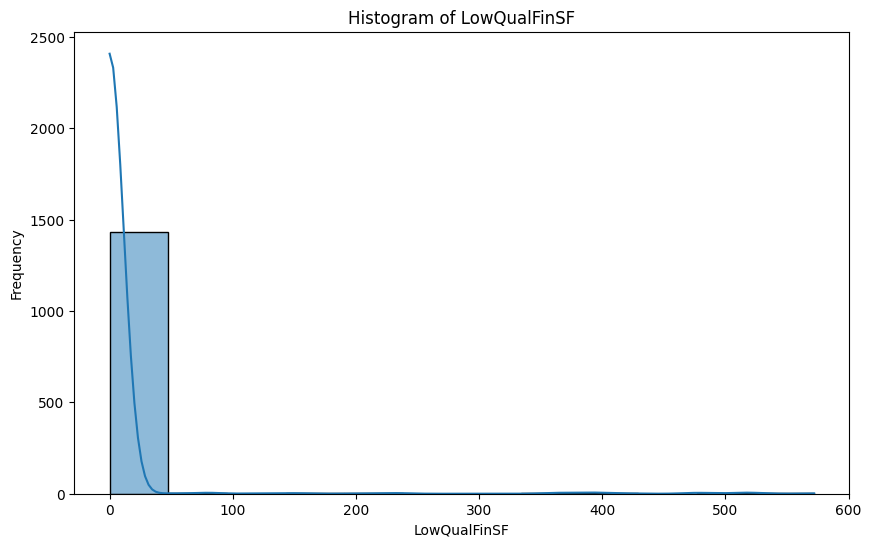

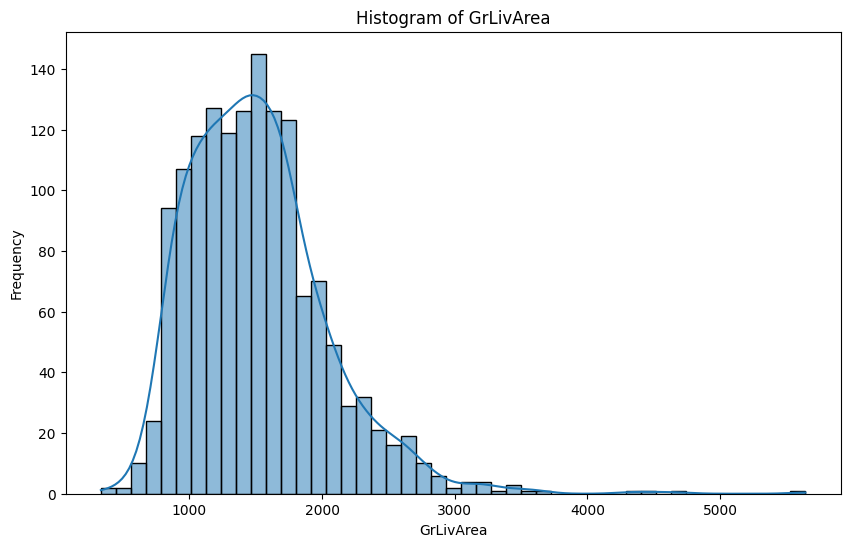

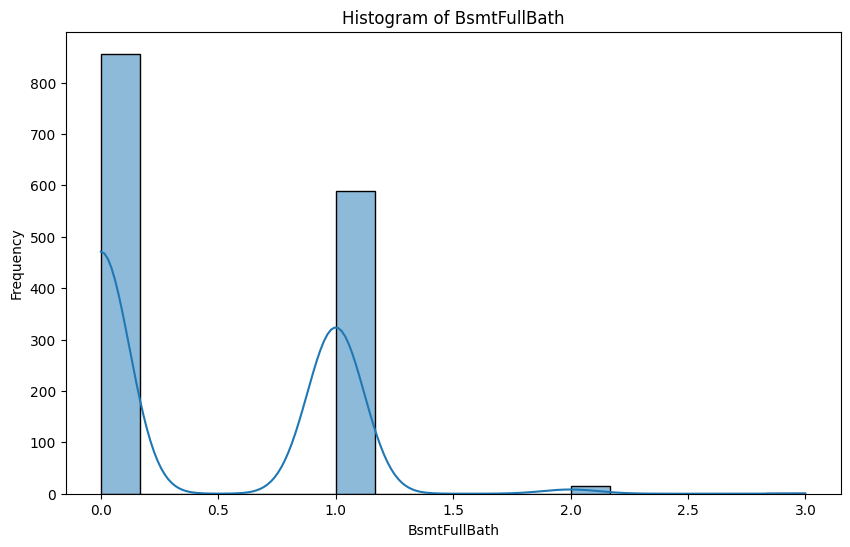

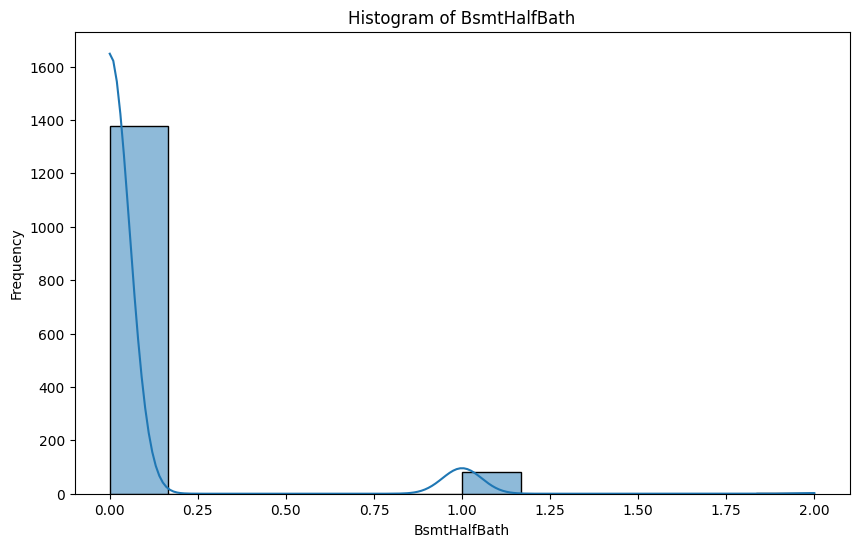

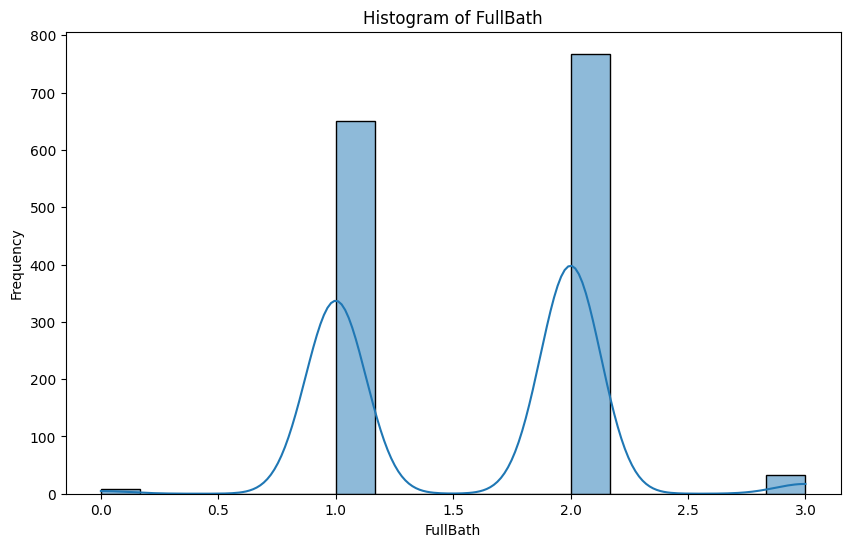

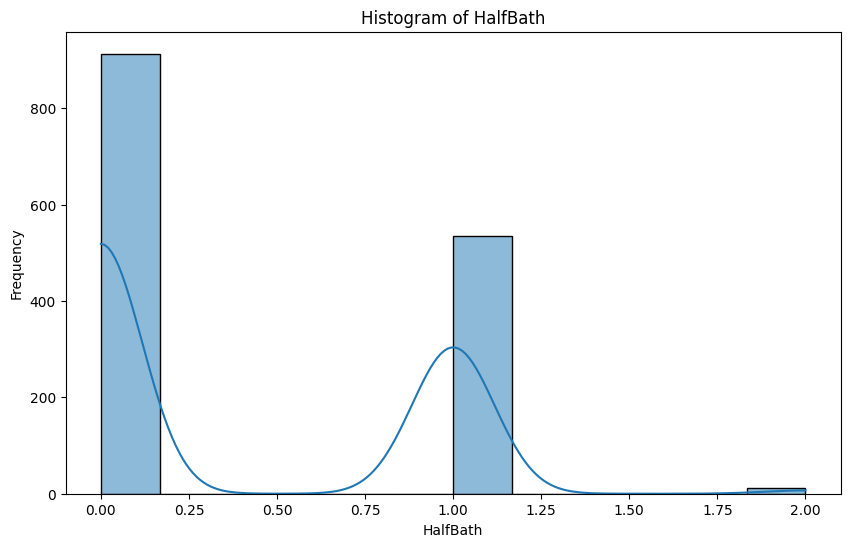

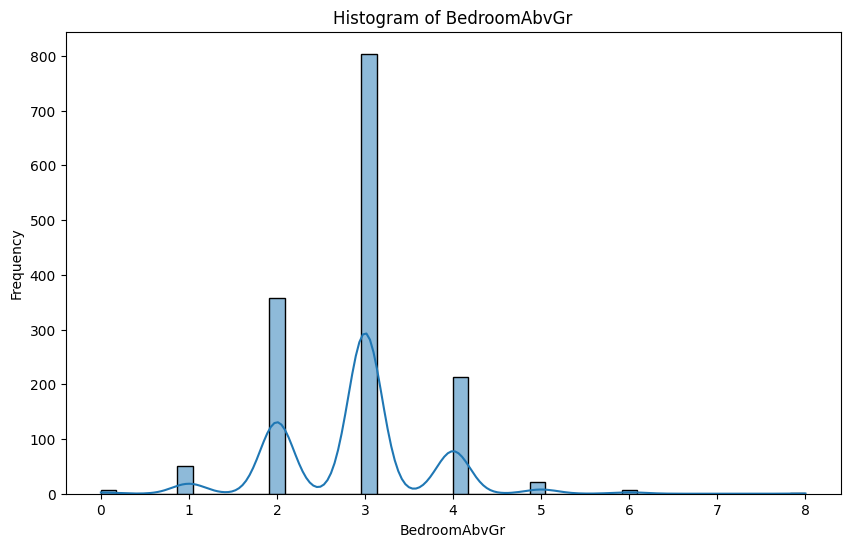

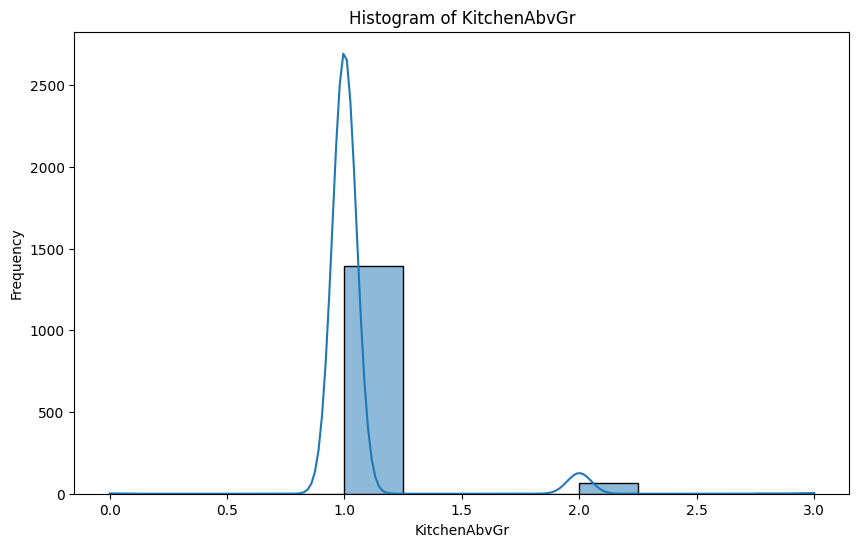

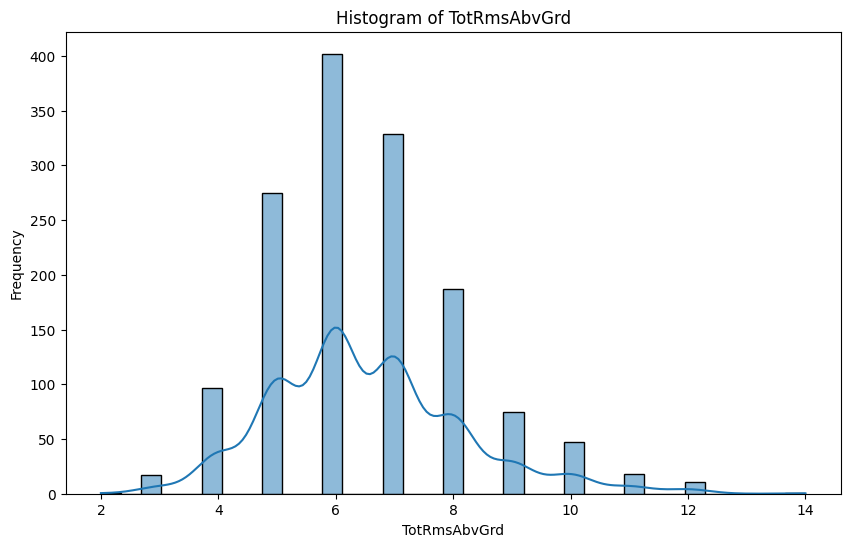

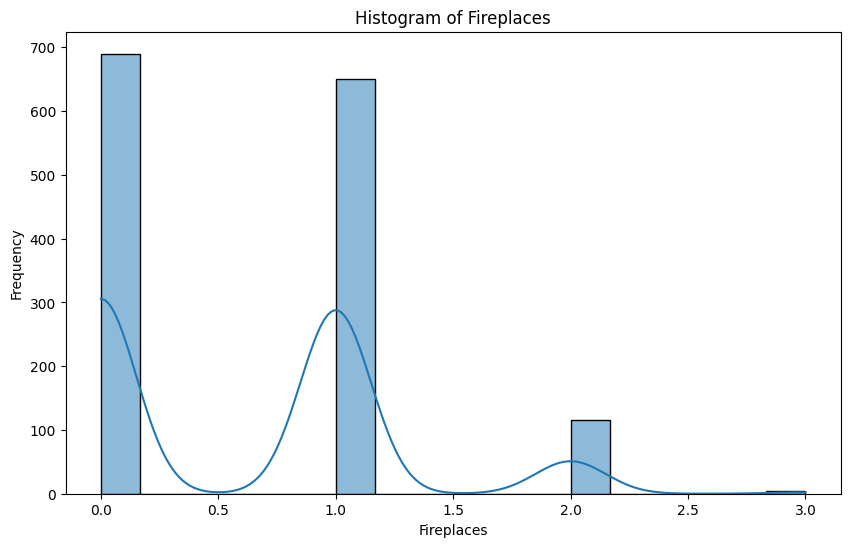

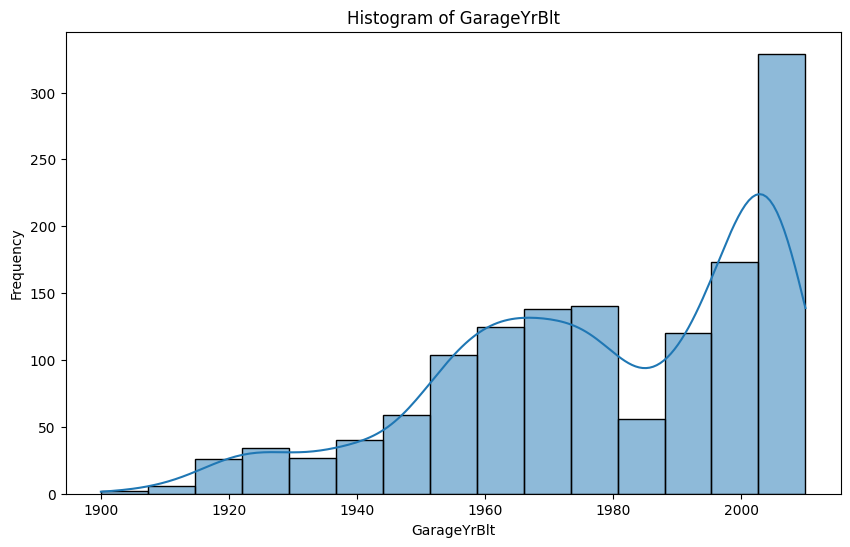

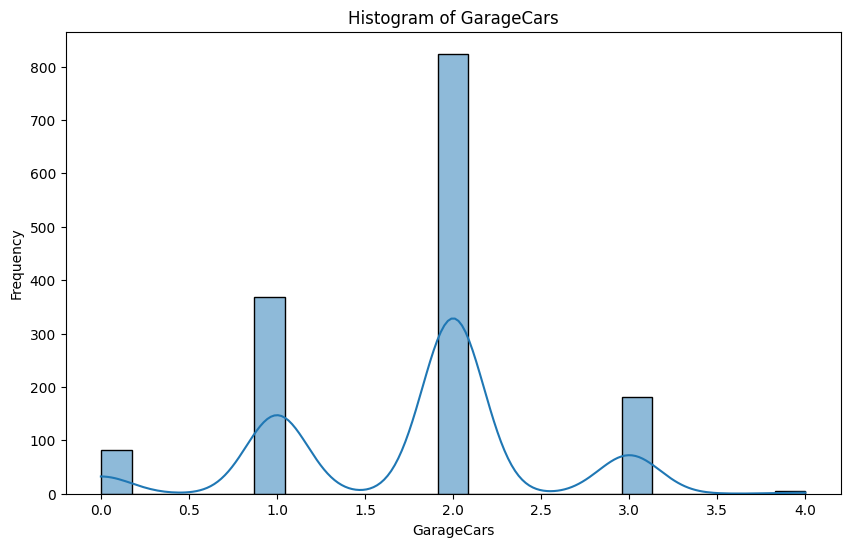

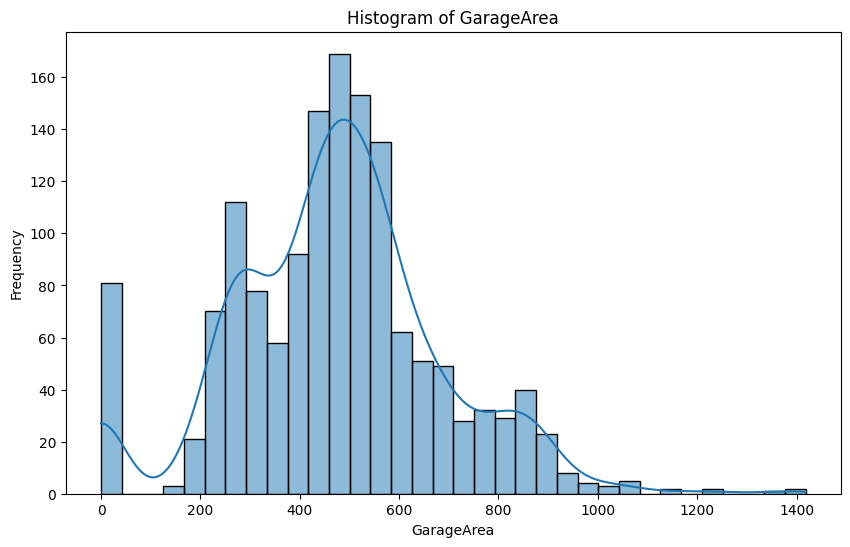

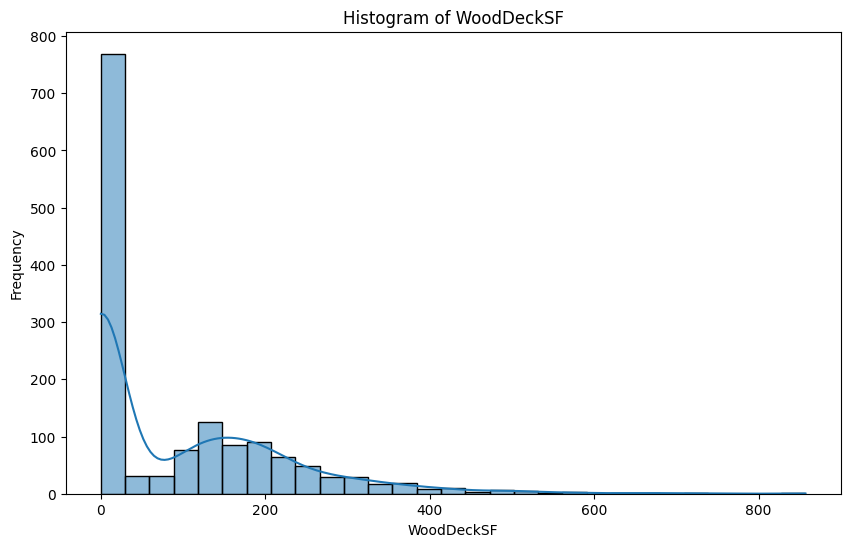

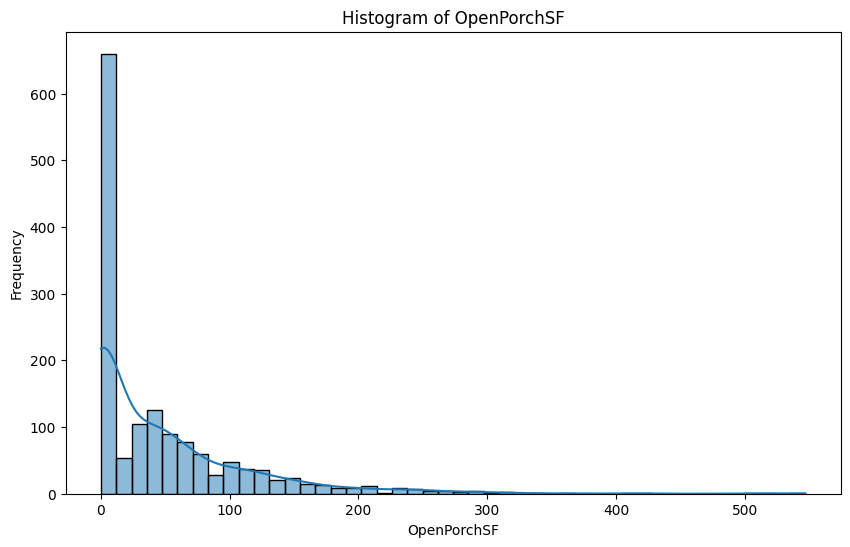

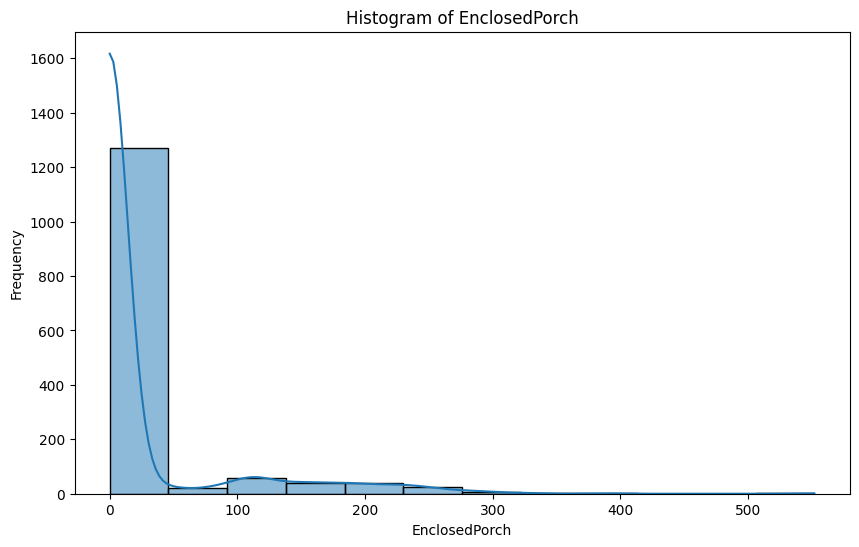

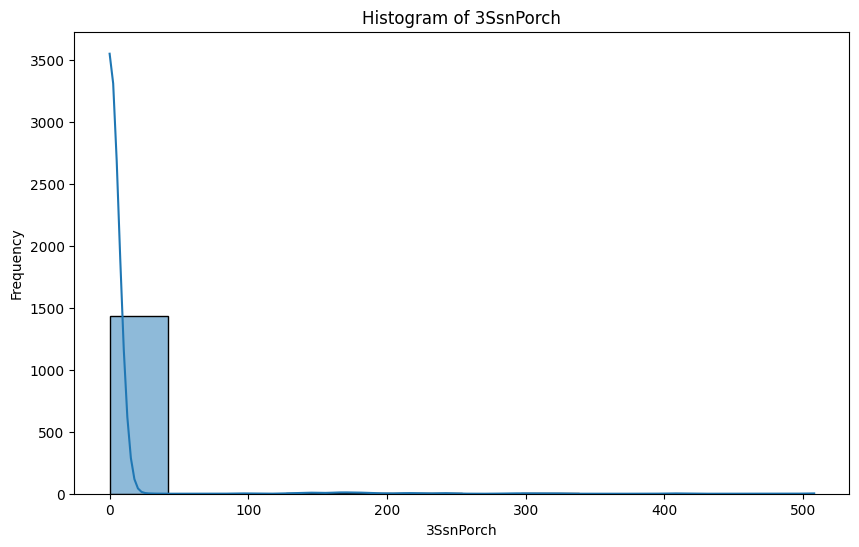

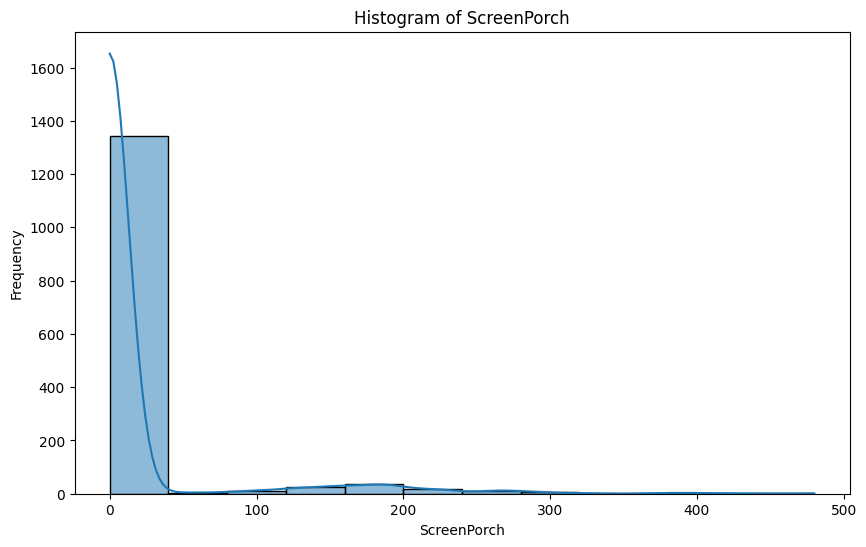

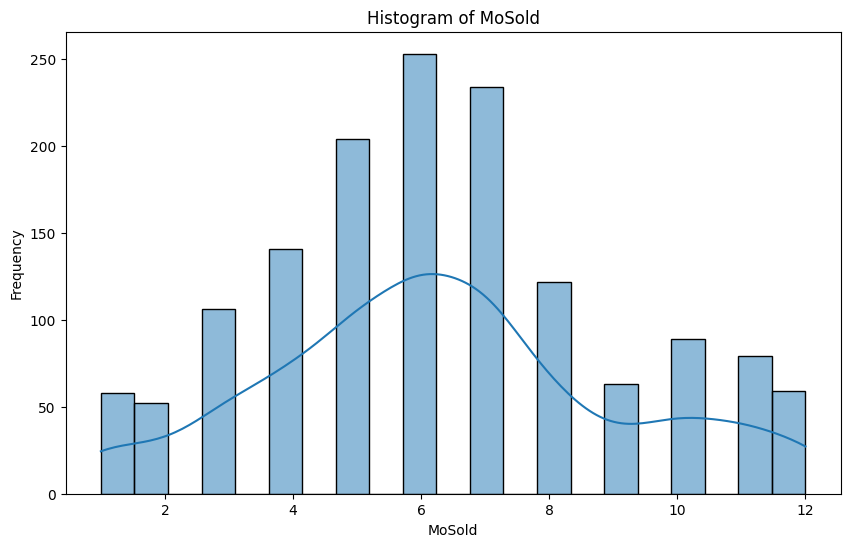

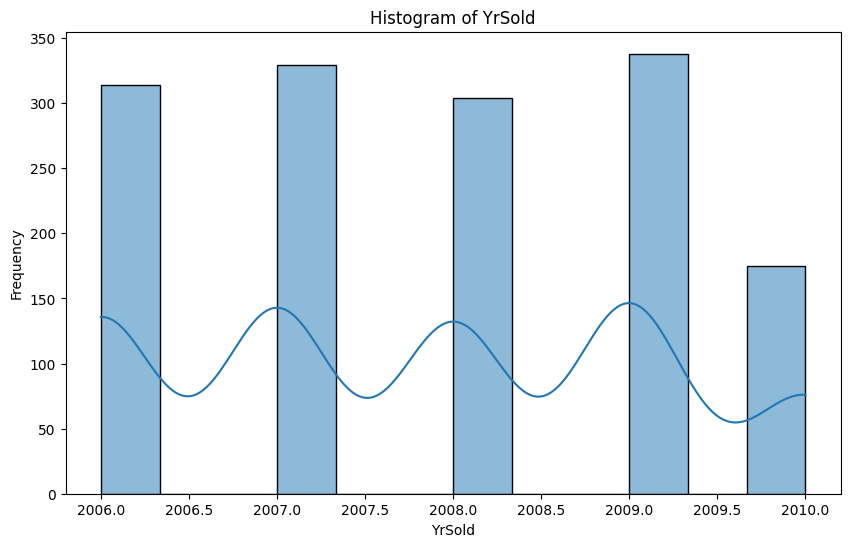

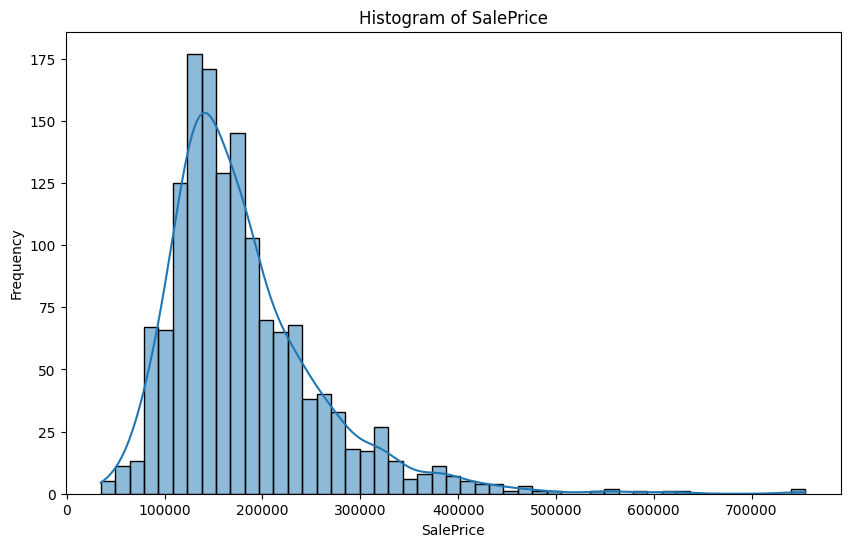

In [20]:
# We'll leave the remaining colummns as is for now and move onto looking for outliers
# Loop through each column in the DataFrame
for column in train.columns:
    # Check if the column is of numeric type (int or float)
    if train[column].dtype in ['int64', 'float64']:
        # Plot a histogram for the column
        plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
        sns.histplot(train[column], kde=True)  # kde=True adds a density curve
        plt.title(f'Histogram of {column}')
        plt.xlabel(column)
        plt.ylabel('Frequency')
        plt.show()


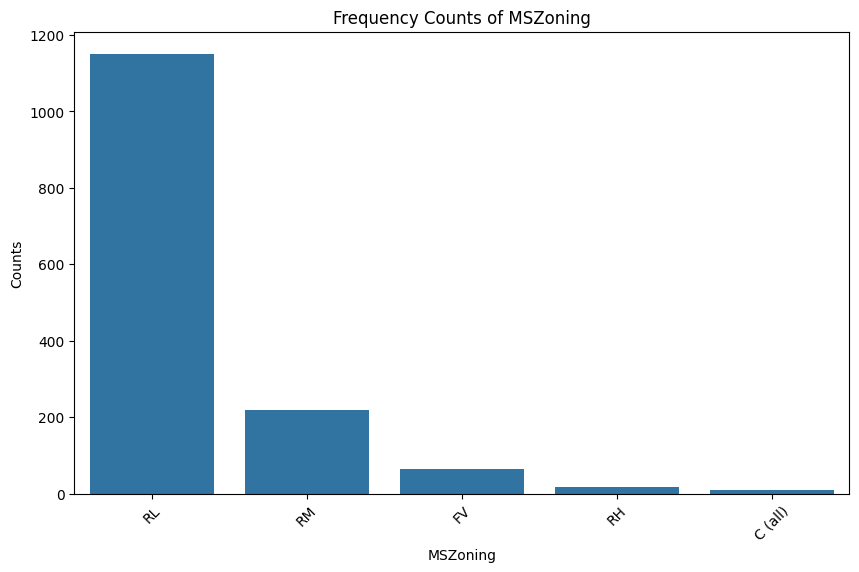

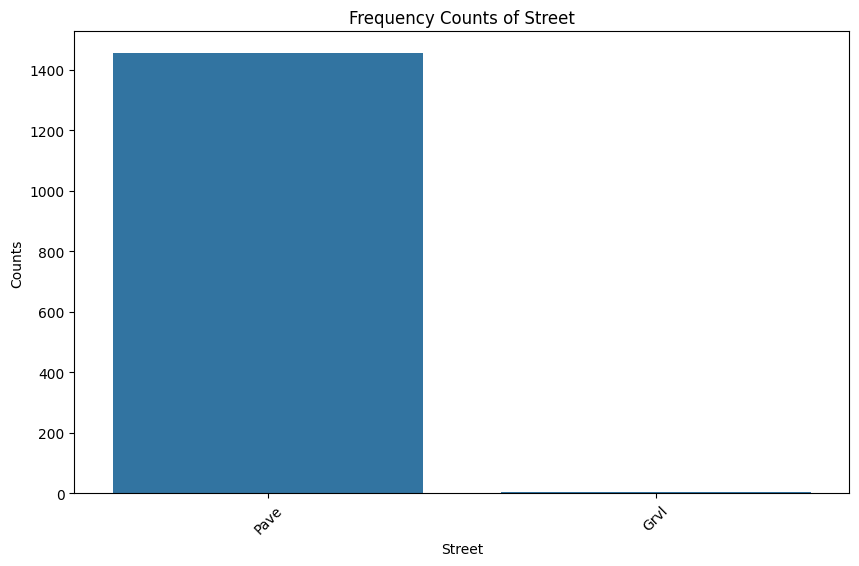

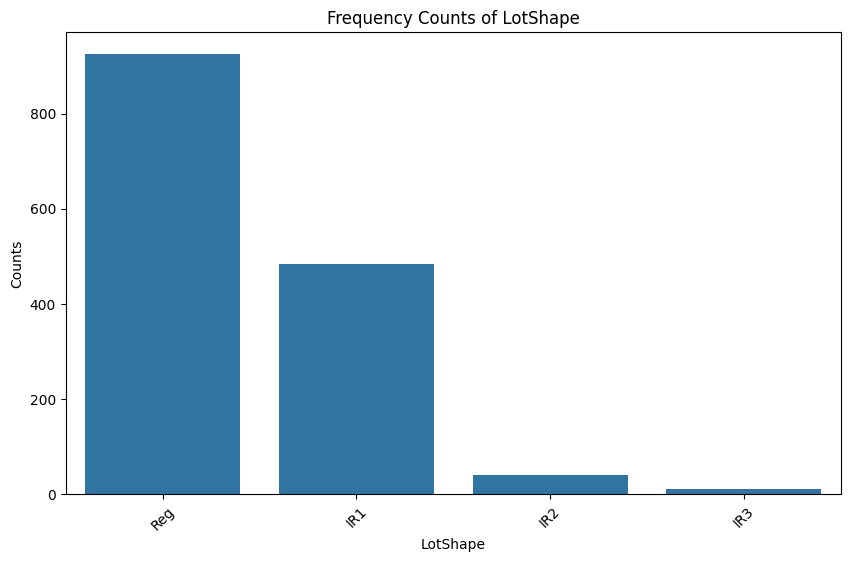

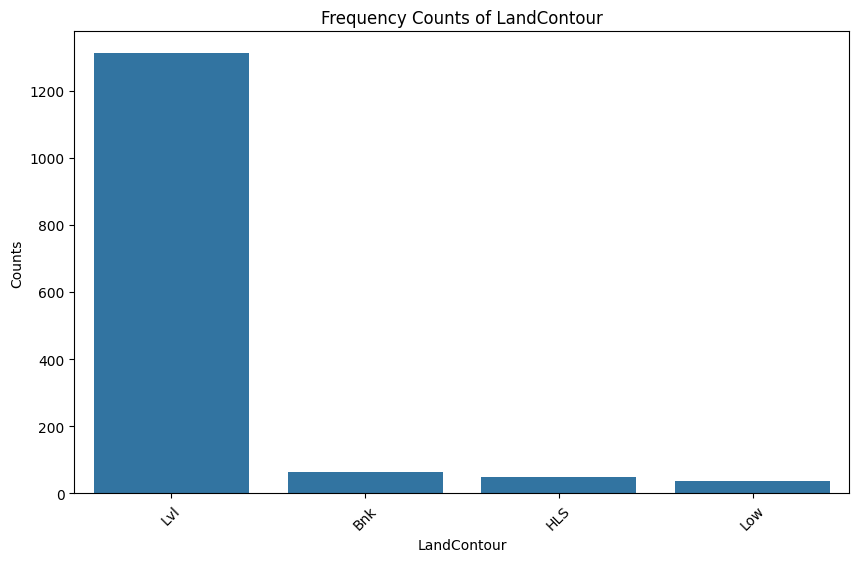

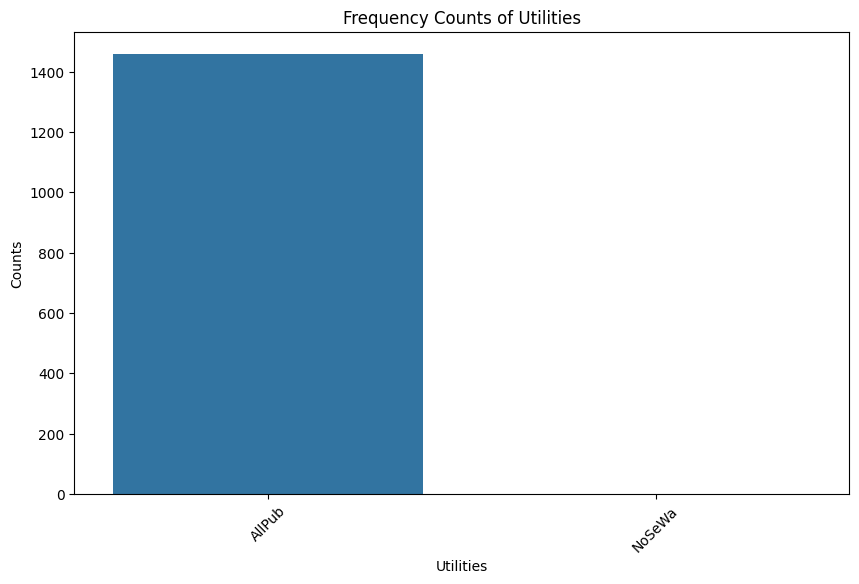

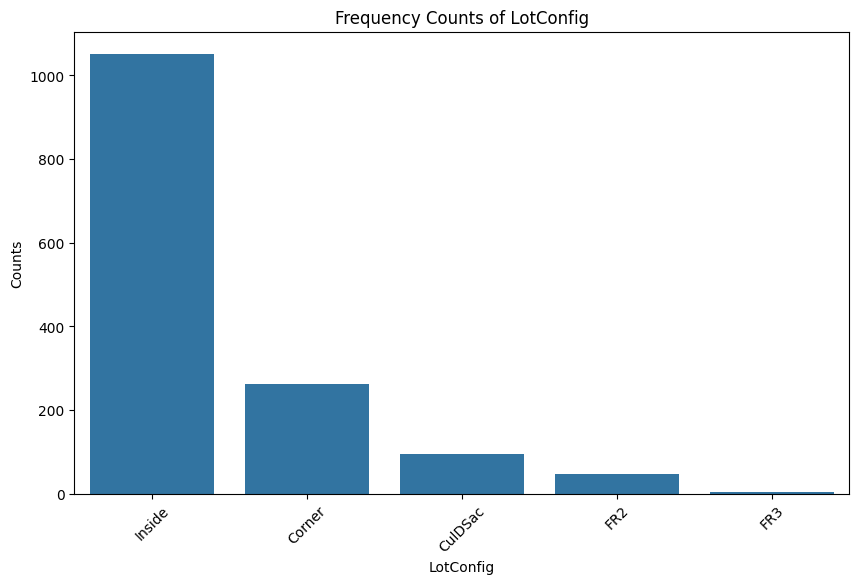

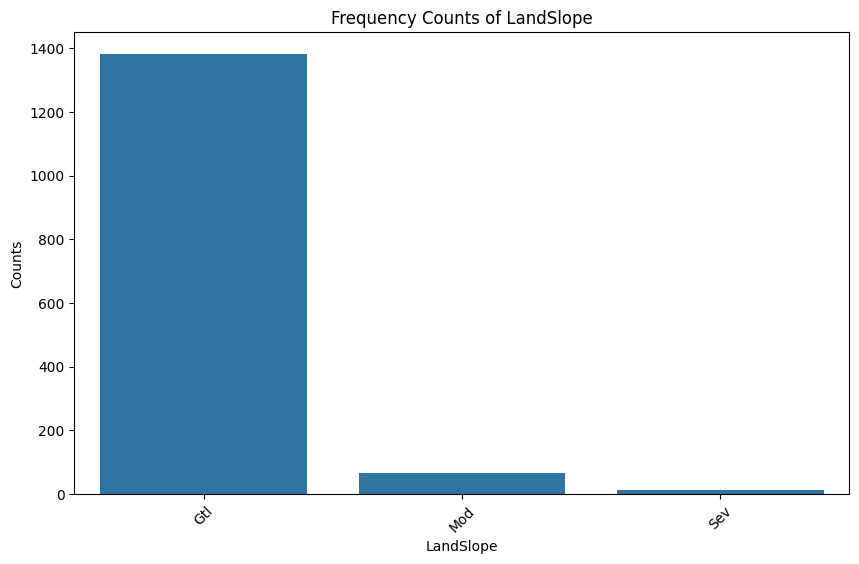

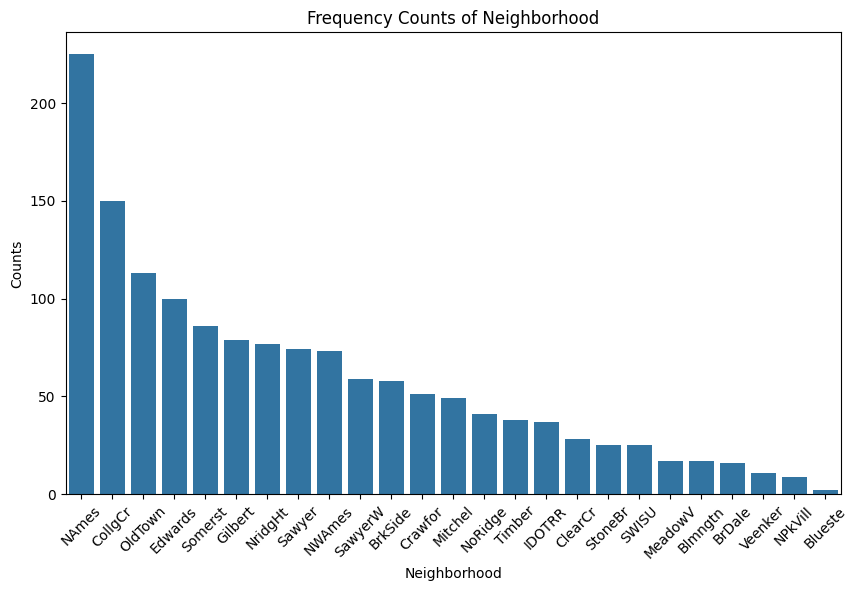

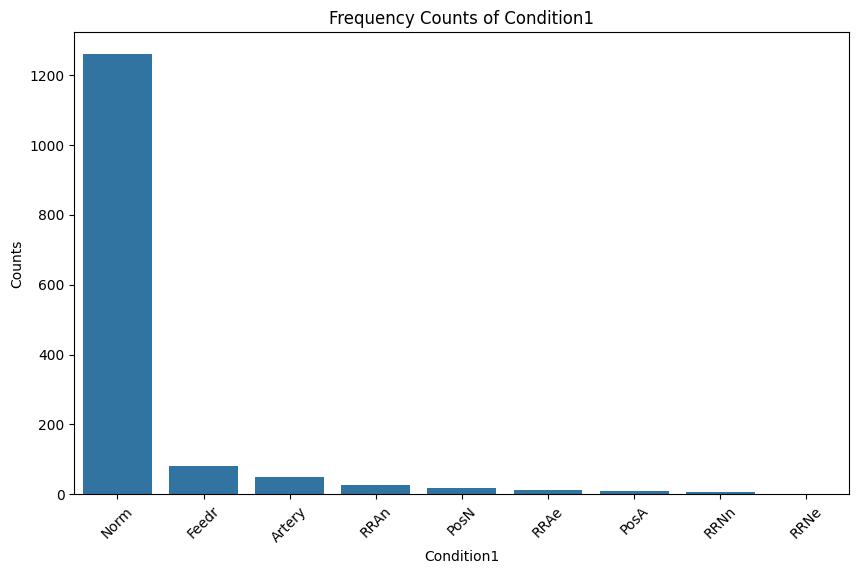

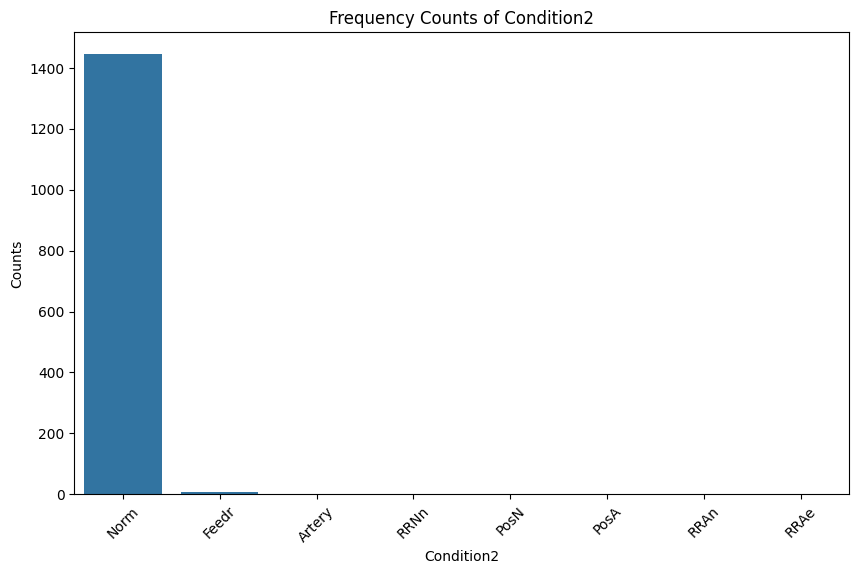

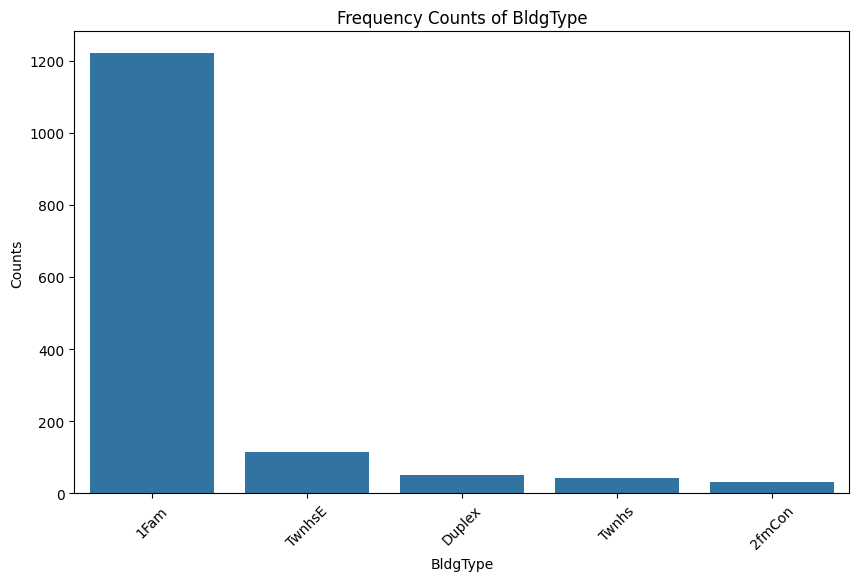

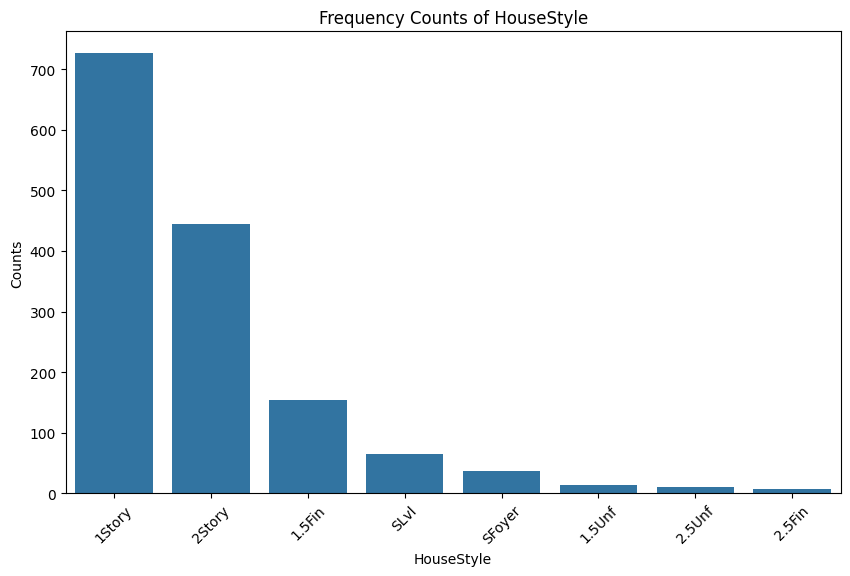

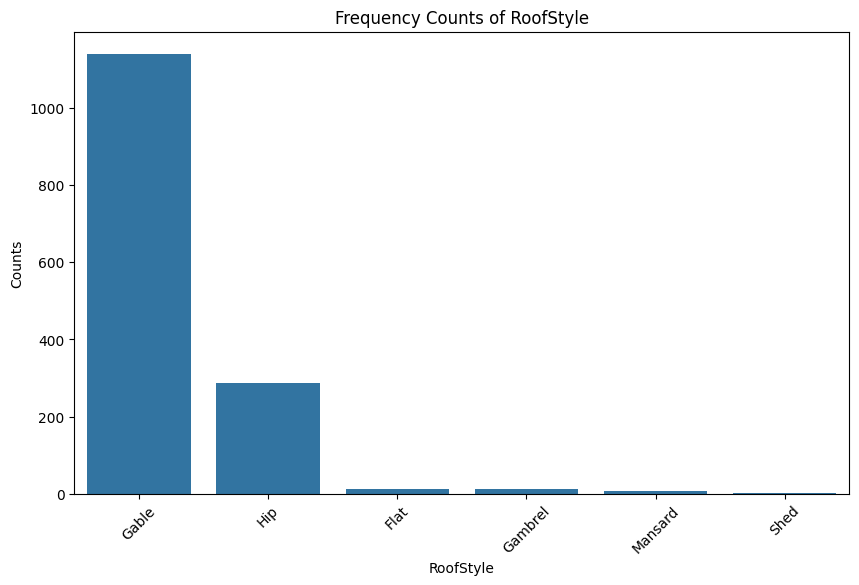

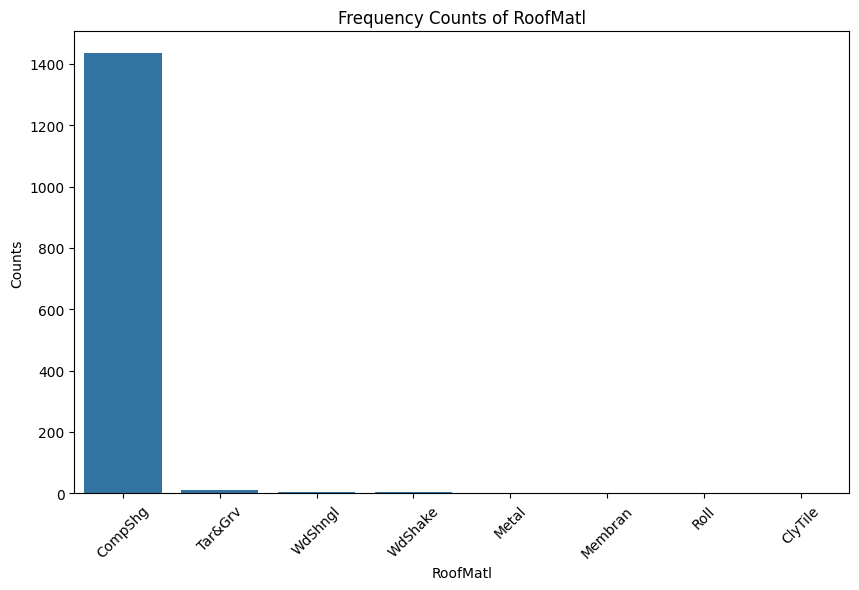

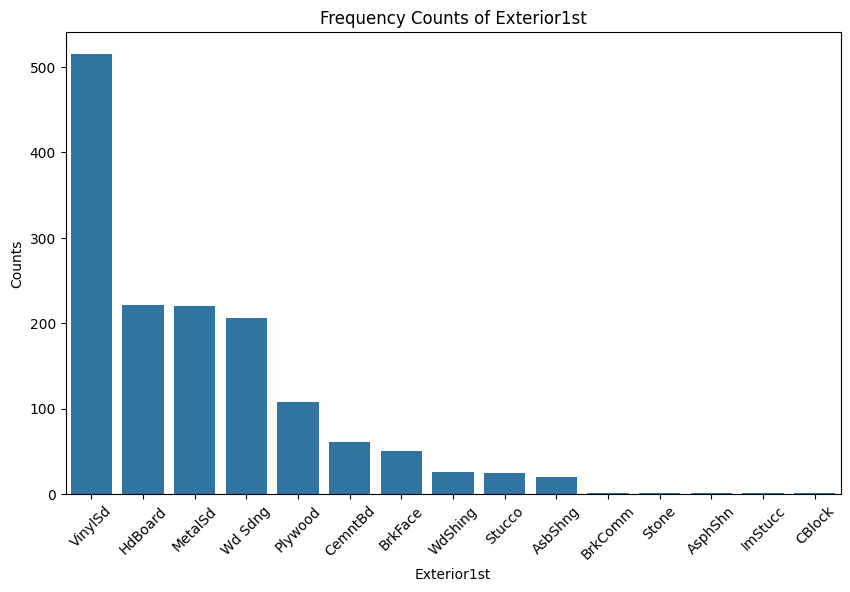

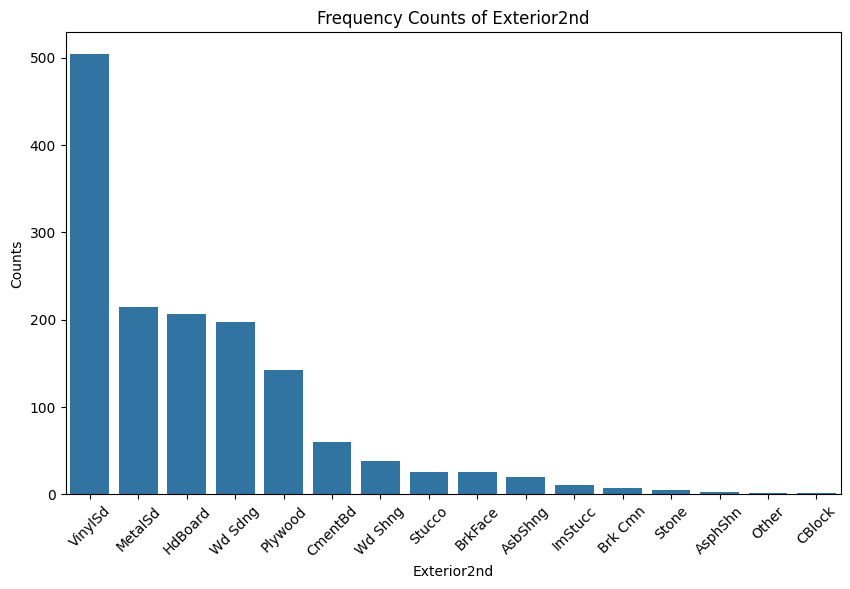

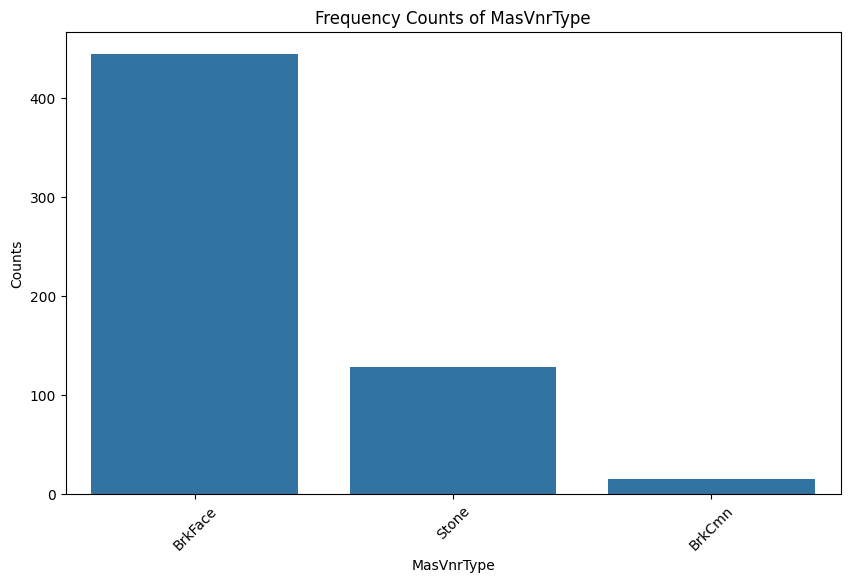

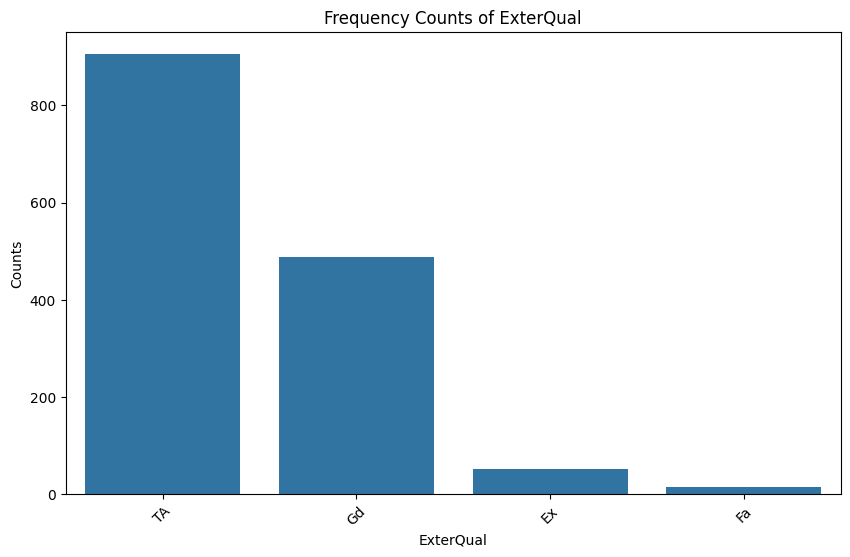

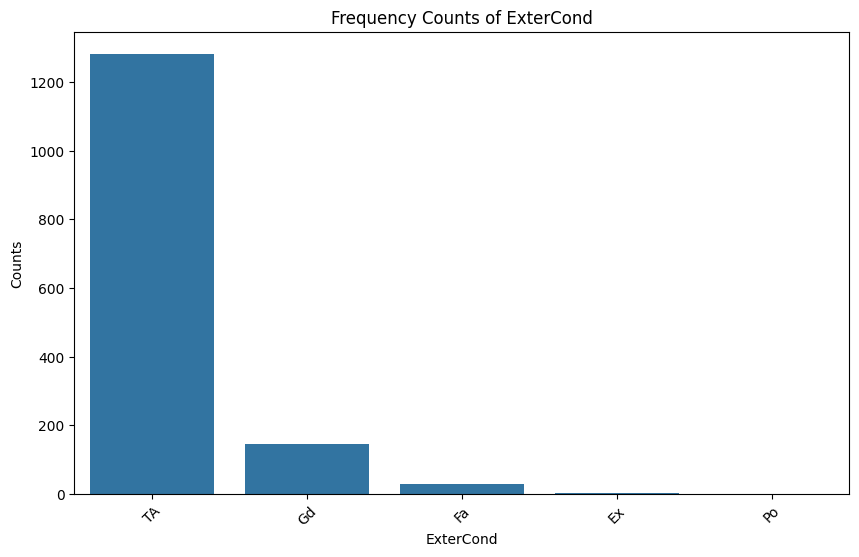

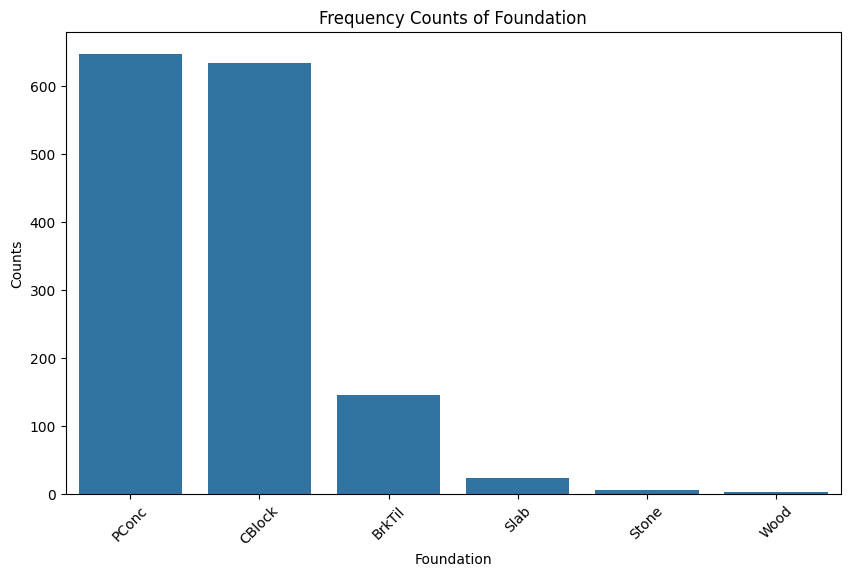

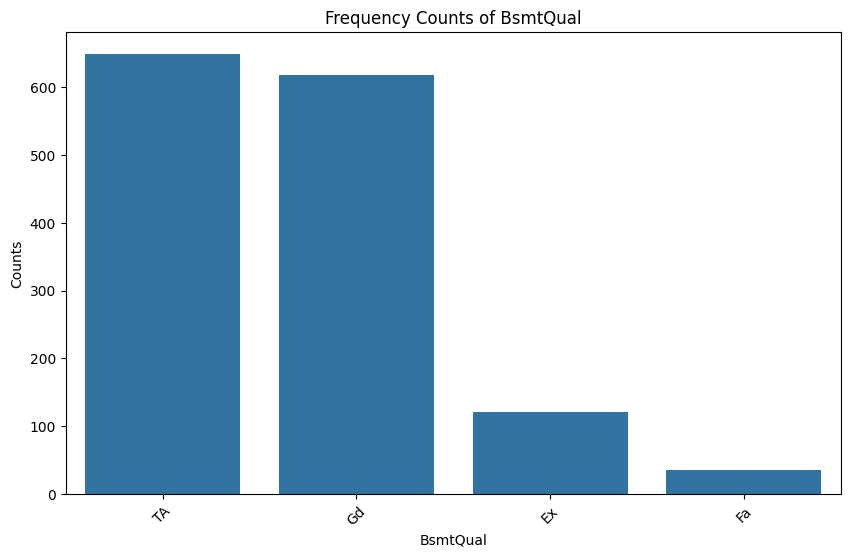

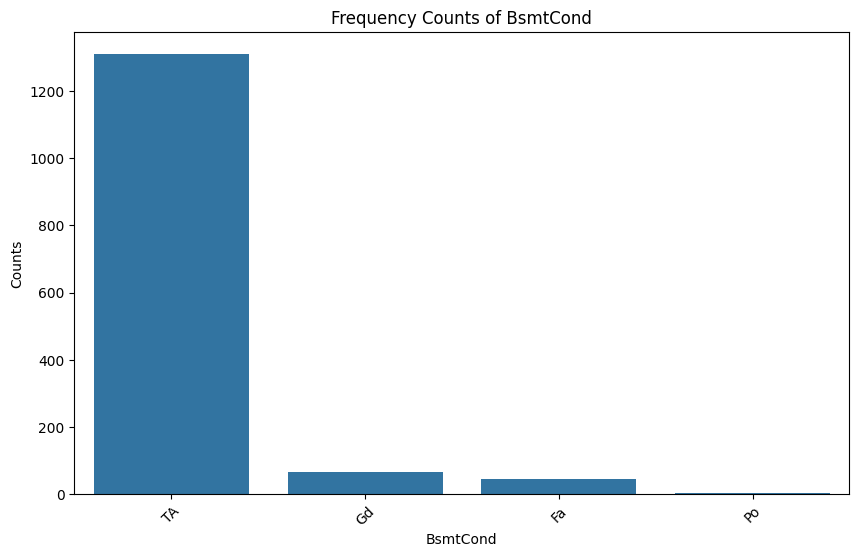

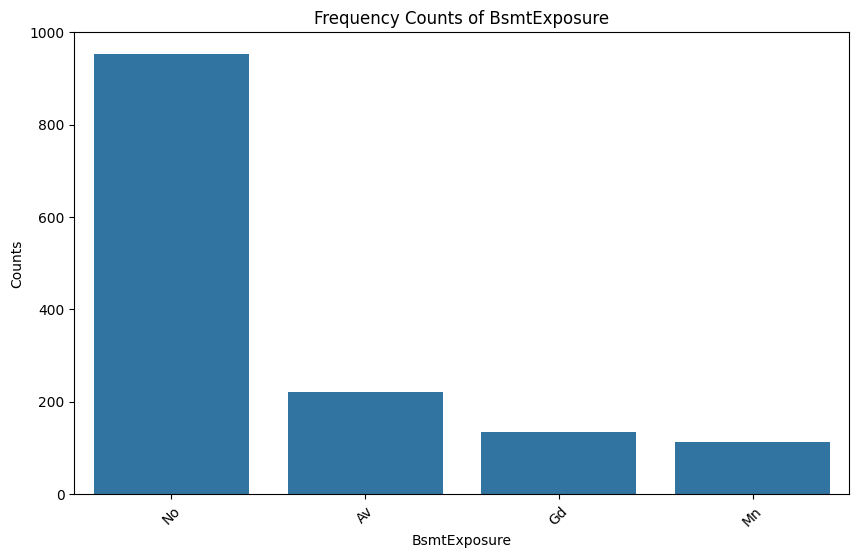

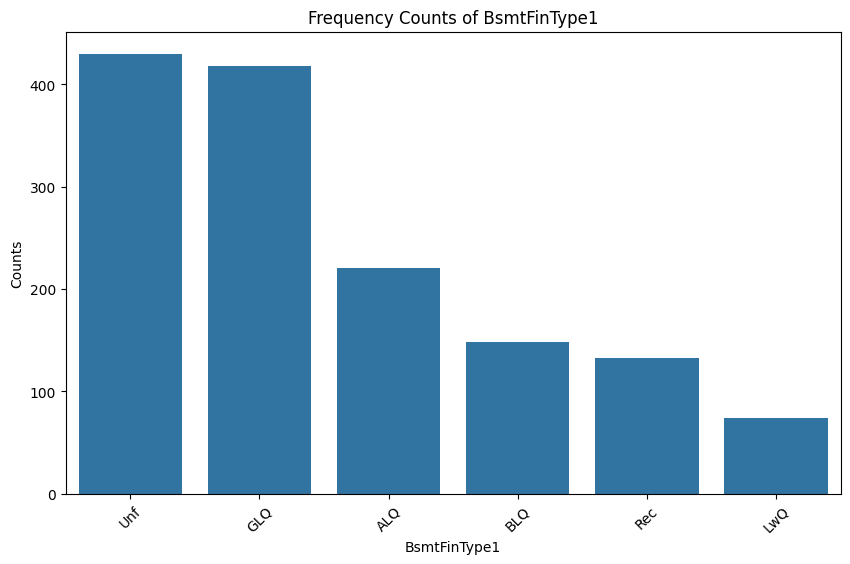

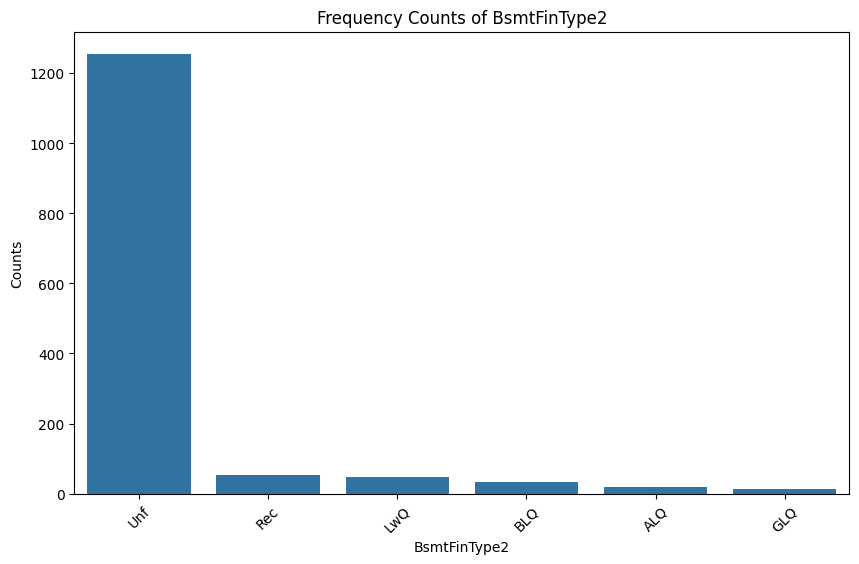

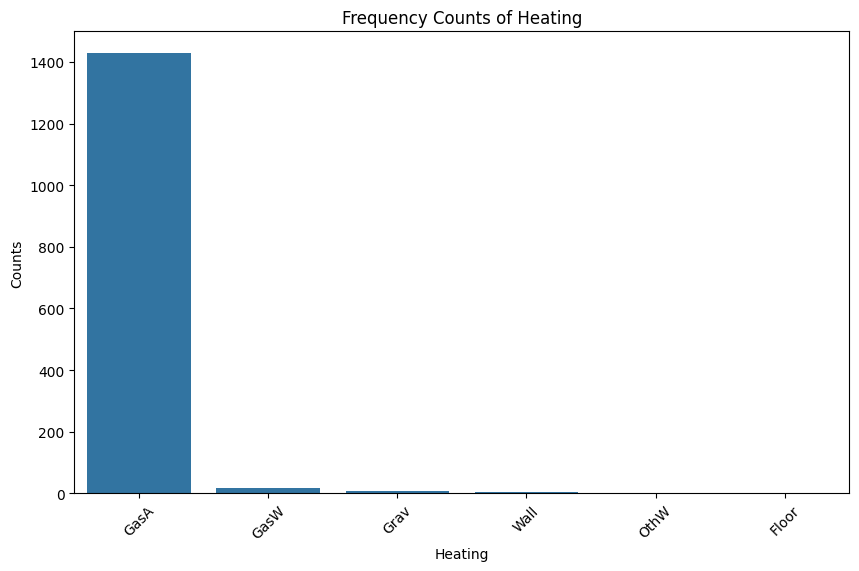

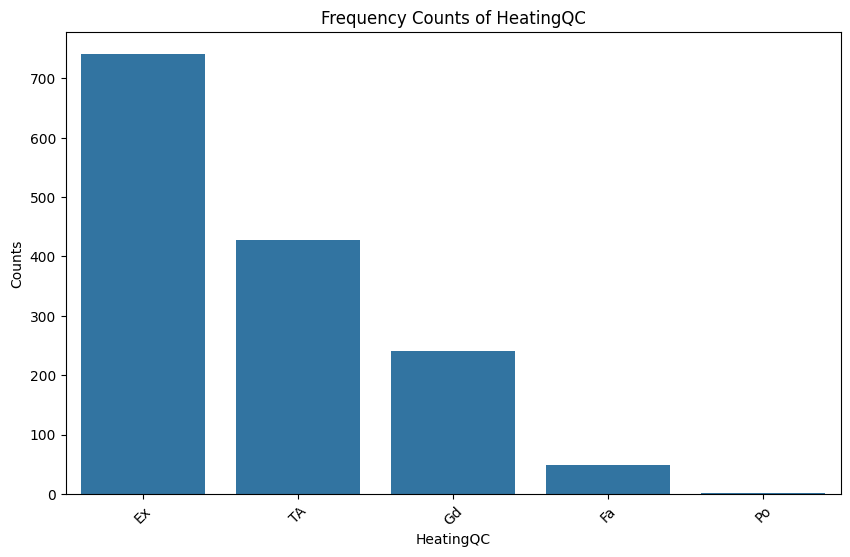

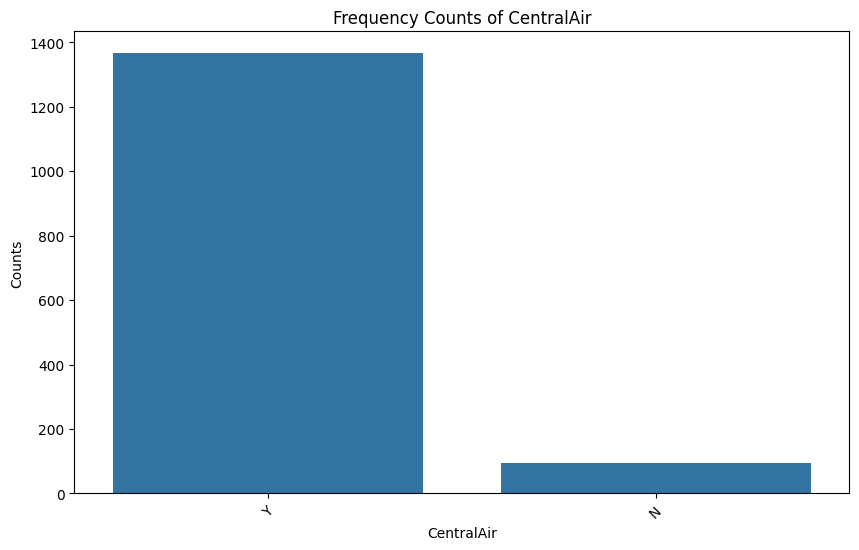

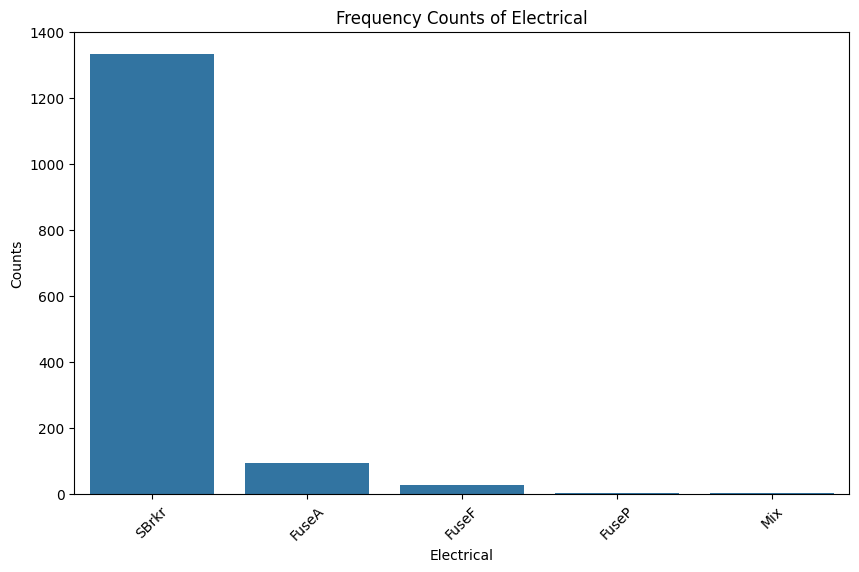

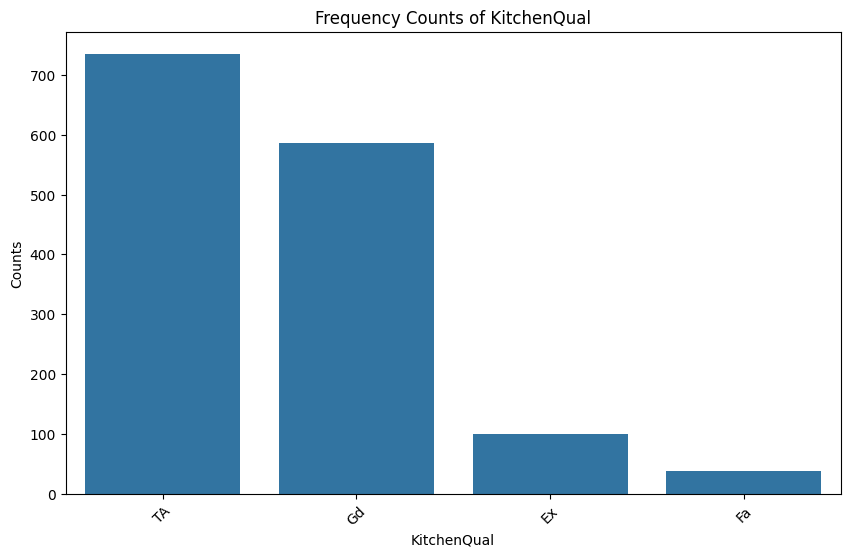

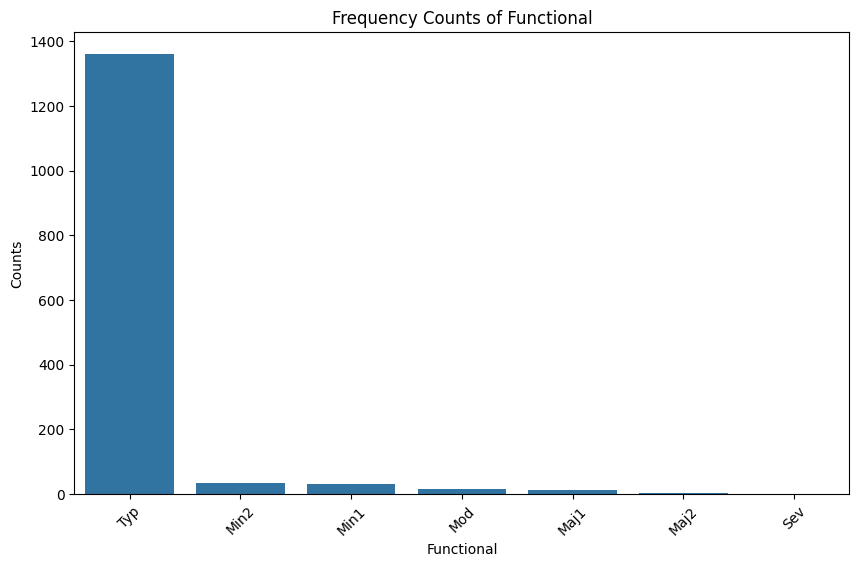

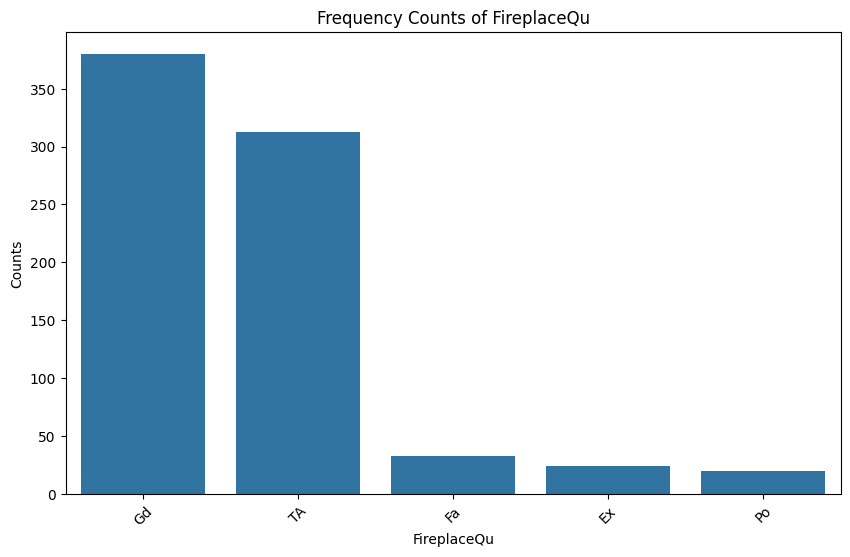

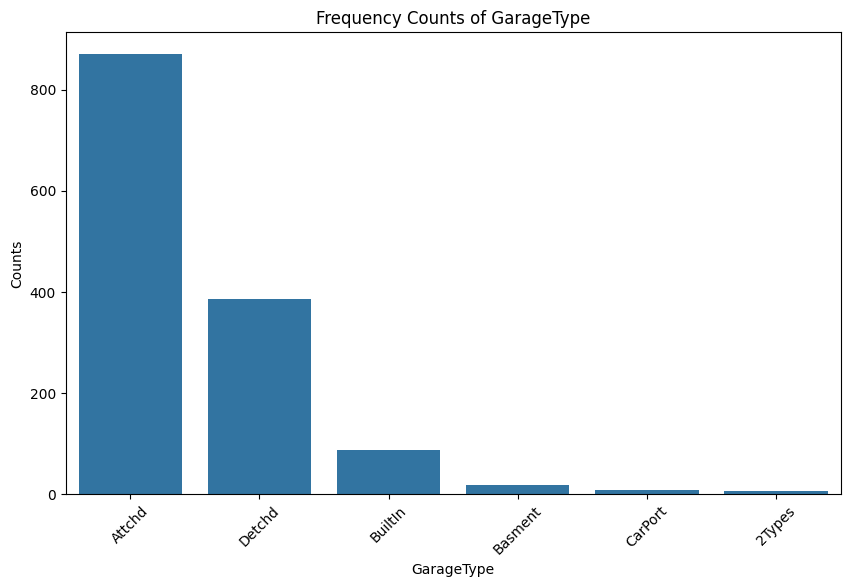

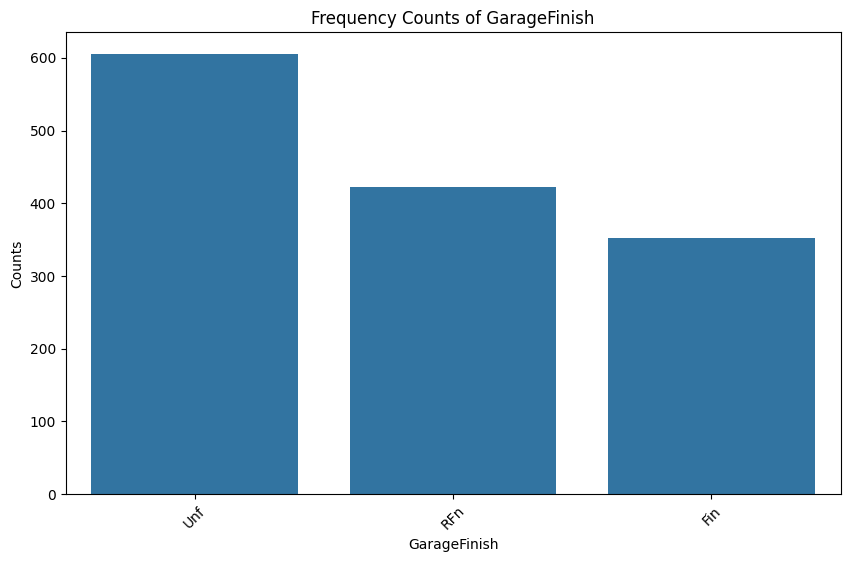

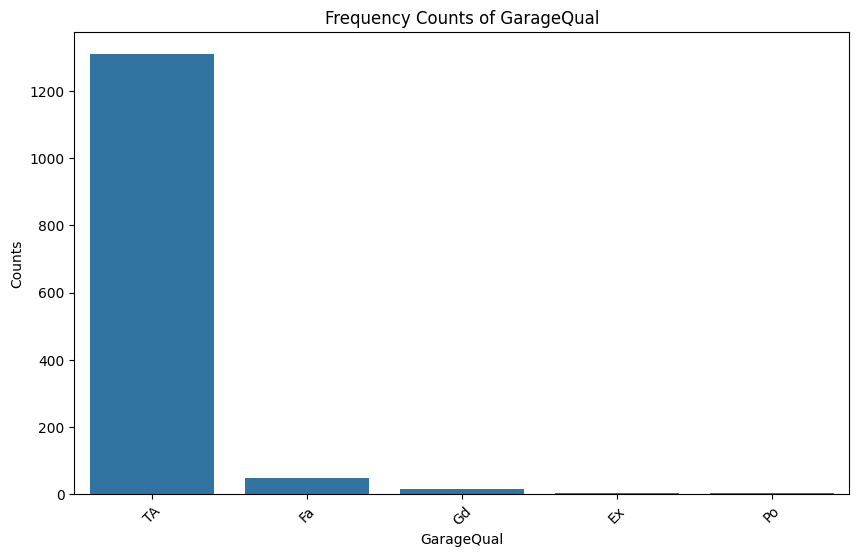

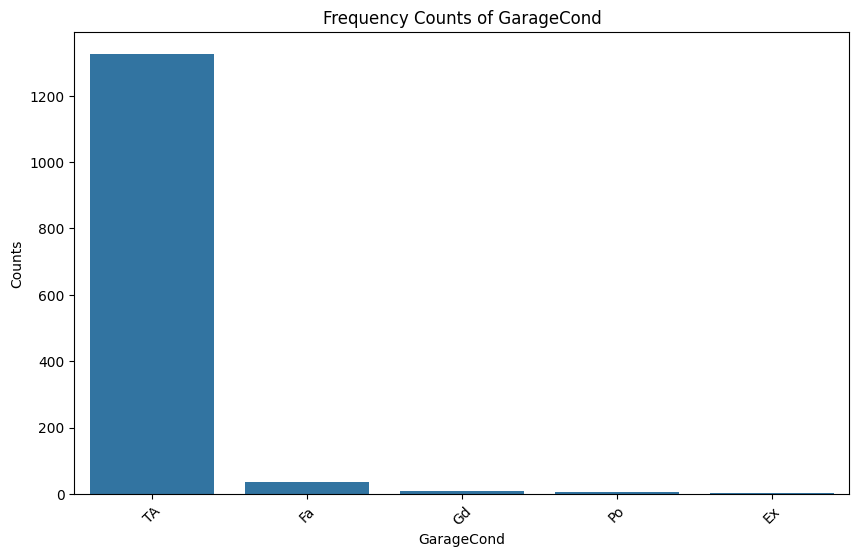

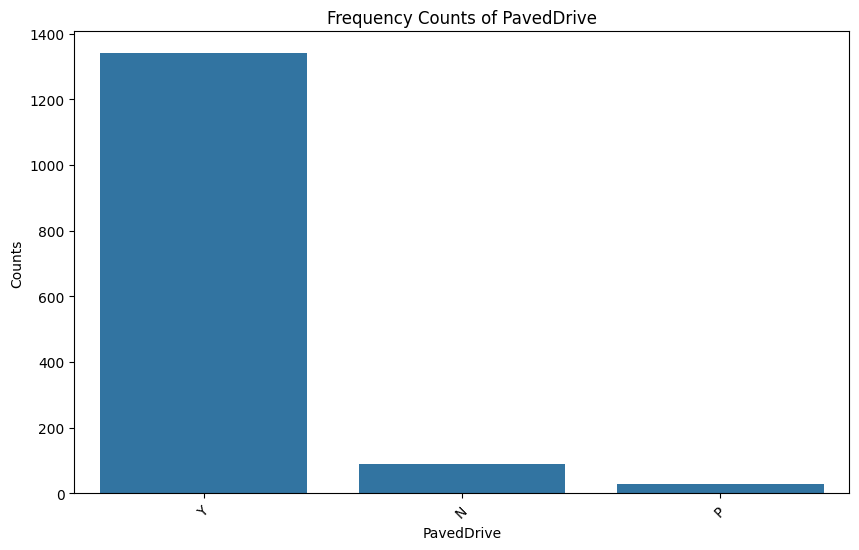

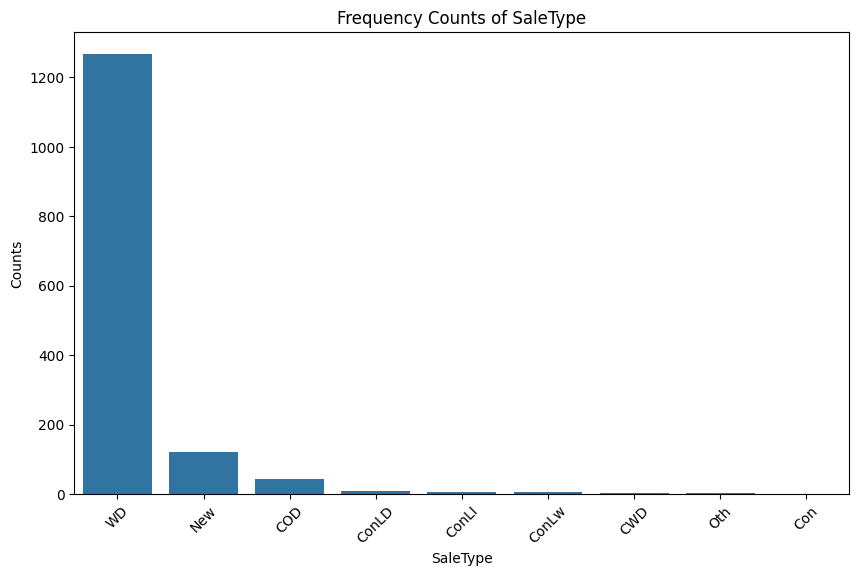

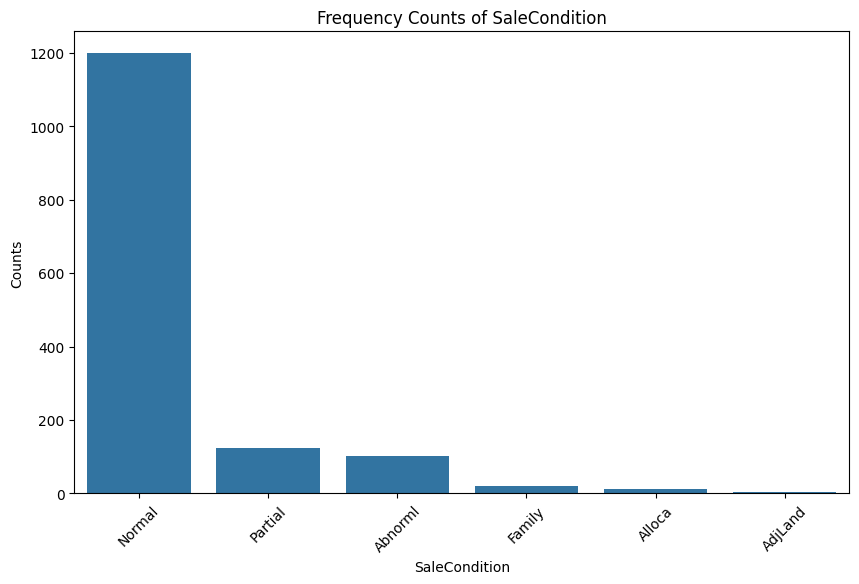

In [21]:
# Next we'll do the same for categorical columns
# Loop through each column in the DataFrame
for column in train.columns:
    # Check if the column is of object type
    if train[column].dtype == 'object':
        # Calculate frequency counts of the column's values
        frequency_counts = train[column].value_counts()

        # Create a bar plot for the frequency counts
        plt.figure(figsize=(10, 6))  # Optional: Adjust figure size
        sns.barplot(x=frequency_counts.index, y=frequency_counts.values)
        plt.title(f'Frequency Counts of {column}')
        plt.xticks(rotation=45)  # Rotate labels to avoid overlap
        plt.xlabel(column)
        plt.ylabel('Counts')
        plt.show()

In [22]:
# Let's look at correlations for numerical columns
# There are a few numerical columns that are actually categorical, so we'll filter those first



# Let's do some feature engineering
# Let's create a column for bed and bath ratio (bath here is full and half baths above grade combined)
train['Bed_bath_Ratio'] = train['BedroomAbvGr'] / (train['FullBath'])
test['Bed_bath_Ratio'] = test['BedroomAbvGr'] / (test['FullBath'])
# Let's also look at lotarea vs GrLivArea
train['lot_vs_grlivarea'] = train['LotArea'] / train['GrLivArea']
test['lot_vs_grlivarea'] = test['LotArea'] / test['GrLivArea']
# Calculate total house sq ft
train['combinedsqft'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF']
test['combinedsqft'] = test['1stFlrSF'] + test['2ndFlrSF'] + test['TotalBsmtSF']
# Columns to use
int_cols = train[['LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch',
       'MoSold', 'YrSold', 'SalePrice', 'Bed_bath_Ratio', 'lot_vs_grlivarea', 'combinedsqft']]

correlations = int_cols.corr()

In [23]:
# Unstack the correlation matrix to convert it into a Series
corr_series = correlations.unstack()

# Remove self-correlations (correlation of variables with themselves)
corr_series = corr_series[corr_series.index.get_level_values(0) != corr_series.index.get_level_values(1)]

# Sort the values from largest to smallest (in absolute value if needed)
sorted_correlations = corr_series.abs().sort_values(ascending=False)

# If you want to see the actual correlation values (positive and negative) sorted by their absolute value
sorted_correlations_actual = corr_series.loc[sorted_correlations.index]

# Display the sorted correlations
print(sorted_correlations_actual)

LotArea           lot_vs_grlivarea    0.890946
lot_vs_grlivarea  LotArea             0.890946
GarageArea        GarageCars          0.882475
GarageCars        GarageArea          0.882475
combinedsqft      GrLivArea           0.874373
GrLivArea         combinedsqft        0.874373
TotalBsmtSF       combinedsqft        0.826742
combinedsqft      TotalBsmtSF         0.826742
GarageYrBlt       YearBuilt           0.825667
YearBuilt         GarageYrBlt         0.825667
TotRmsAbvGrd      GrLivArea           0.825489
GrLivArea         TotRmsAbvGrd        0.825489
TotalBsmtSF       1stFlrSF            0.819530
1stFlrSF          TotalBsmtSF         0.819530
combinedsqft      1stFlrSF            0.800350
1stFlrSF          combinedsqft        0.800350
OverallQual       SalePrice           0.790982
SalePrice         OverallQual         0.790982
combinedsqft      SalePrice           0.782260
SalePrice         combinedsqft        0.782260
                  GrLivArea           0.708624
GrLivArea    

In [24]:
correlations.style.background_gradient(cmap='coolwarm')

<Axes: >

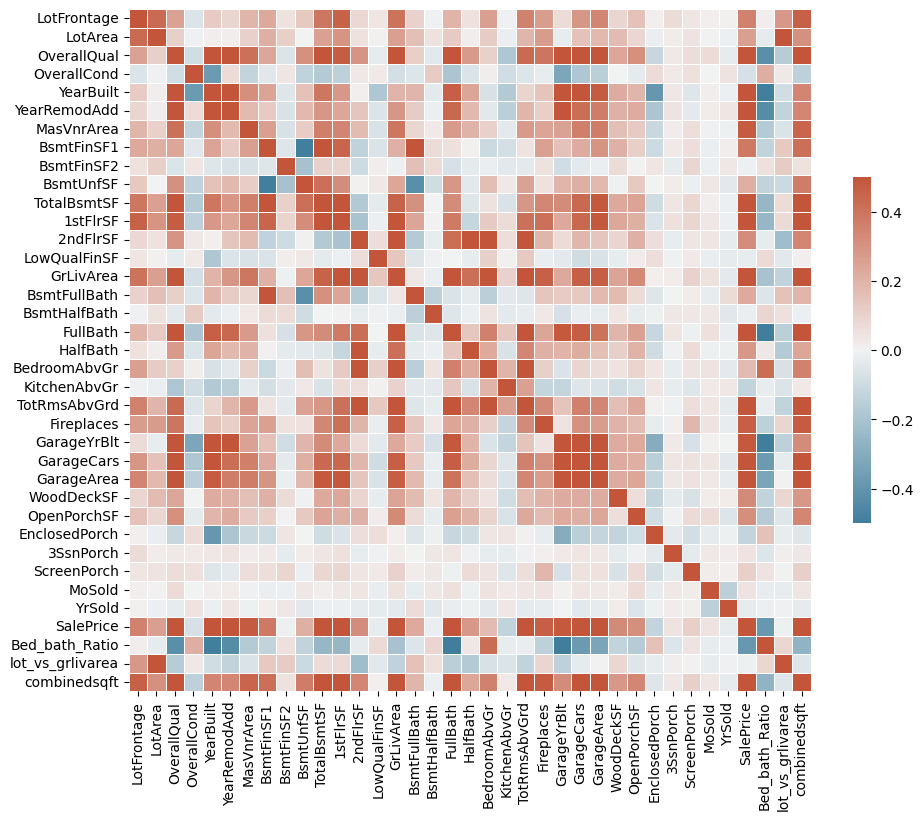

In [25]:
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)


# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlations,
            cmap=cmap, vmax=.5, vmin=-.5, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

Text(0, 0.5, 'Mean Sale Price')

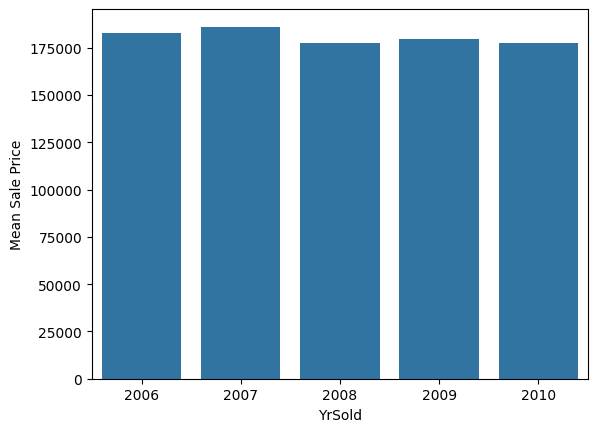

In [26]:
# Let's plot sale price versus yrsold
agg_yrsold_price = train.groupby('YrSold').SalePrice.mean()
sns.barplot(agg_yrsold_price)
plt.ylabel("Mean Sale Price")

Text(0, 0.5, 'Mean Sale Price')

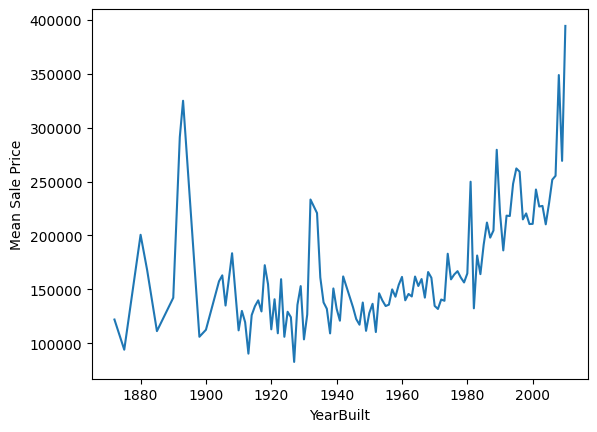

In [27]:
# Let's plot sale price versus yrbuilt
agg_yrbuilt_price = train.groupby('YearBuilt').SalePrice.mean()
sns.lineplot(agg_yrbuilt_price)
plt.ylabel("Mean Sale Price")

Text(0, 0.5, 'Mean Sale Price')

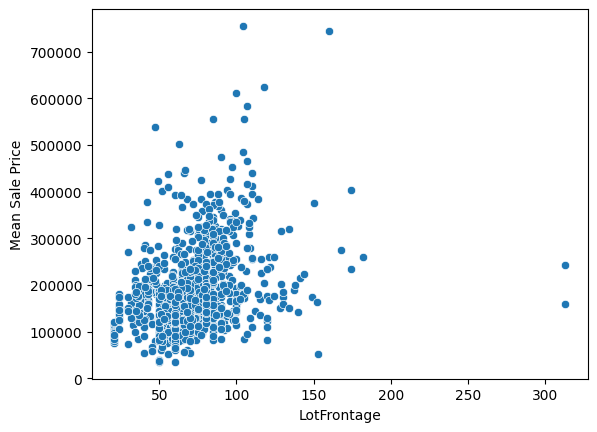

In [28]:
# Let's plot sale price versus lotfrontage
sns.scatterplot(train, x=train.LotFrontage, y=train.SalePrice)
plt.ylabel("Mean Sale Price")

Text(0, 0.5, 'Mean Sale Price')

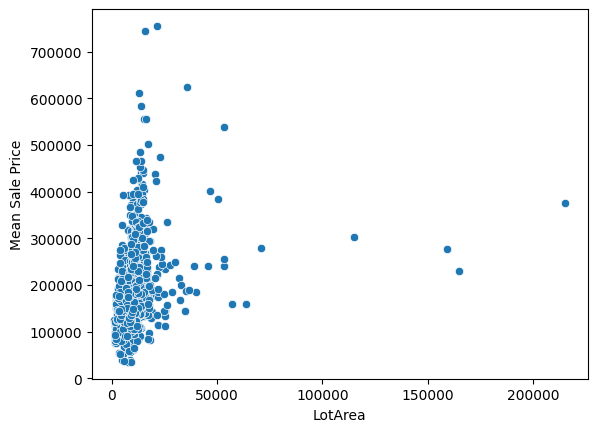

In [29]:
# Let's plot sale price versus lotarea
sns.scatterplot(train, x=train.LotArea, y=train.SalePrice)
plt.ylabel("Mean Sale Price")

Text(0, 0.5, 'Mean Sale Price')

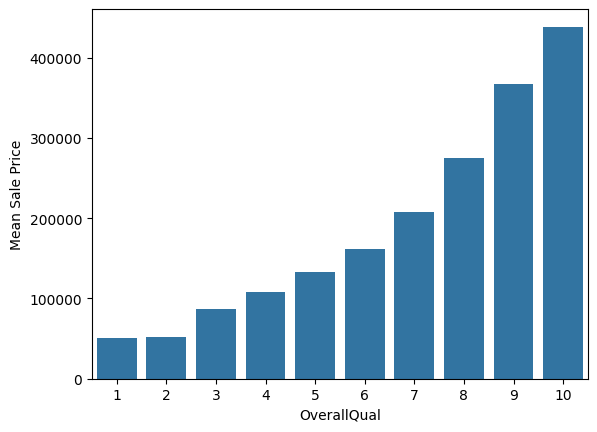

In [30]:
# Let's plot sale price versus OverallQual
agg_overallqual_price = train.groupby('OverallQual').SalePrice.mean()
sns.barplot(agg_overallqual_price)
plt.ylabel("Mean Sale Price")

Text(0, 0.5, 'Mean Sale Price')

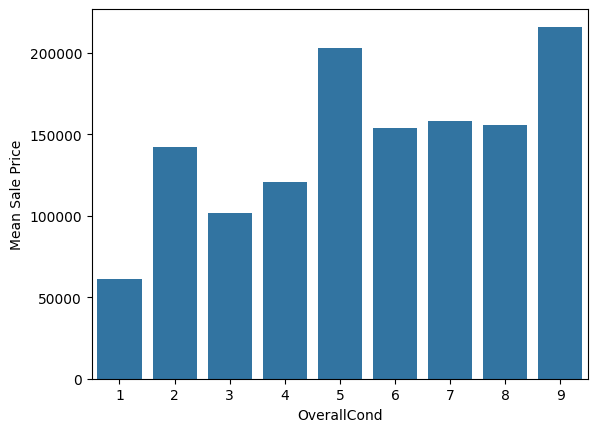

In [31]:
# Let's plot sale price versus OverallCond
agg_OverallCond_price = train.groupby('OverallCond').SalePrice.mean()
sns.barplot(agg_OverallCond_price)
plt.ylabel("Mean Sale Price")

Text(0, 0.5, 'Mean Sale Price')

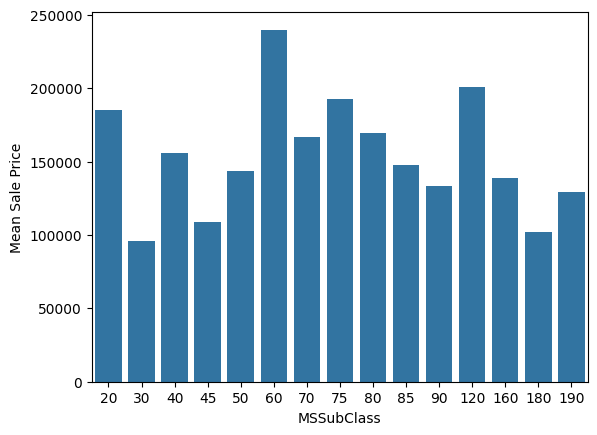

In [32]:
# Let's plot sale price versus MSSubClass
agg_MSSubClass_price = train.groupby('MSSubClass').SalePrice.mean()
sns.barplot(agg_MSSubClass_price)
plt.ylabel("Mean Sale Price")

Text(0, 0.5, 'Mean Sale Price')

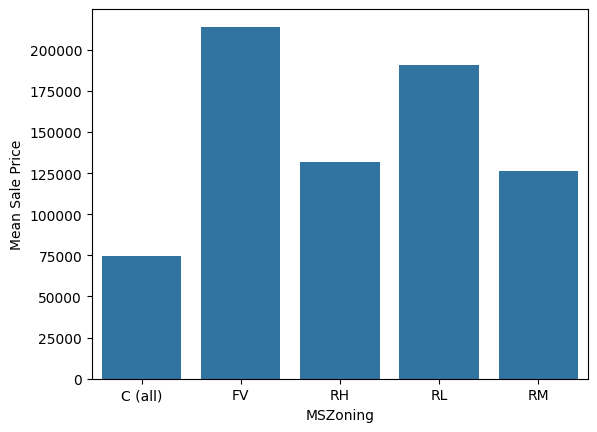

In [33]:
# Let's plot sale price versus MSZoning
agg_MSZoning_price = train.groupby('MSZoning').SalePrice.mean()
sns.barplot(agg_MSZoning_price)
plt.ylabel("Mean Sale Price")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, 'Blmngtn'),
  Text(1, 0, 'Blueste'),
  Text(2, 0, 'BrDale'),
  Text(3, 0, 'BrkSide'),
  Text(4, 0, 'ClearCr'),
  Text(5, 0, 'CollgCr'),
  Text(6, 0, 'Crawfor'),
  Text(7, 0, 'Edwards'),
  Text(8, 0, 'Gilbert'),
  Text(9, 0, 'IDOTRR'),
  Text(10, 0, 'MeadowV'),
  Text(11, 0, 'Mitchel'),
  Text(12, 0, 'NAmes'),
  Text(13, 0, 'NPkVill'),
  Text(14, 0, 'NWAmes'),
  Text(15, 0, 'NoRidge'),
  Text(16, 0, 'NridgHt'),
  Text(17, 0, 'OldTown'),
  Text(18, 0, 'SWISU'),
  Text(19, 0, 'Sawyer'),
  Text(20, 0, 'SawyerW'),
  Text(21, 0, 'Somerst'),
  Text(22, 0, 'StoneBr'),
  Text(23, 0, 'Timber'),
  Text(24, 0, 'Veenker')])

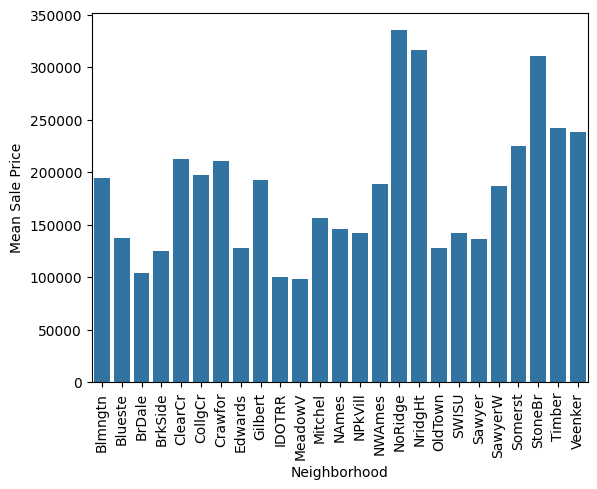

In [34]:
# Let's plot sale price versus Neighborhood
agg_Neighborhood_price = train.groupby('Neighborhood').SalePrice.mean()
sns.barplot(agg_Neighborhood_price)
plt.ylabel("Mean Sale Price")
plt.xticks(rotation=90)

Text(0, 0.5, 'Mean Sale Price')

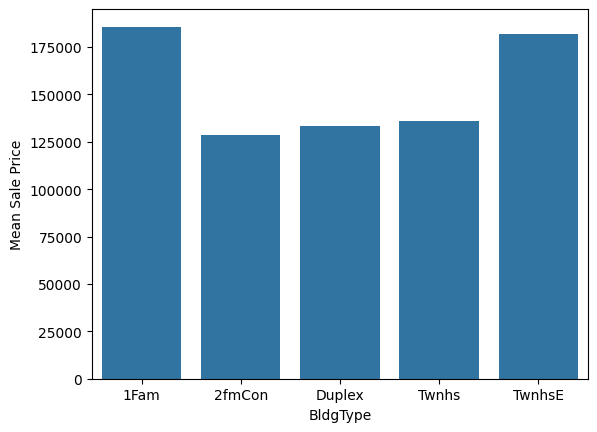

In [35]:
# Let's plot sale price versus BldgType
agg_BldgType_price = train.groupby('BldgType').SalePrice.mean()
sns.barplot(agg_BldgType_price)
plt.ylabel("Mean Sale Price")

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24],
 [Text(0, 0, 'CollgCr'),
  Text(1, 0, 'Veenker'),
  Text(2, 0, 'Crawfor'),
  Text(3, 0, 'NoRidge'),
  Text(4, 0, 'Mitchel'),
  Text(5, 0, 'Somerst'),
  Text(6, 0, 'NWAmes'),
  Text(7, 0, 'OldTown'),
  Text(8, 0, 'BrkSide'),
  Text(9, 0, 'Sawyer'),
  Text(10, 0, 'NridgHt'),
  Text(11, 0, 'NAmes'),
  Text(12, 0, 'SawyerW'),
  Text(13, 0, 'IDOTRR'),
  Text(14, 0, 'MeadowV'),
  Text(15, 0, 'Edwards'),
  Text(16, 0, 'Timber'),
  Text(17, 0, 'Gilbert'),
  Text(18, 0, 'StoneBr'),
  Text(19, 0, 'ClearCr'),
  Text(20, 0, 'NPkVill'),
  Text(21, 0, 'Blmngtn'),
  Text(22, 0, 'BrDale'),
  Text(23, 0, 'SWISU'),
  Text(24, 0, 'Blueste')])

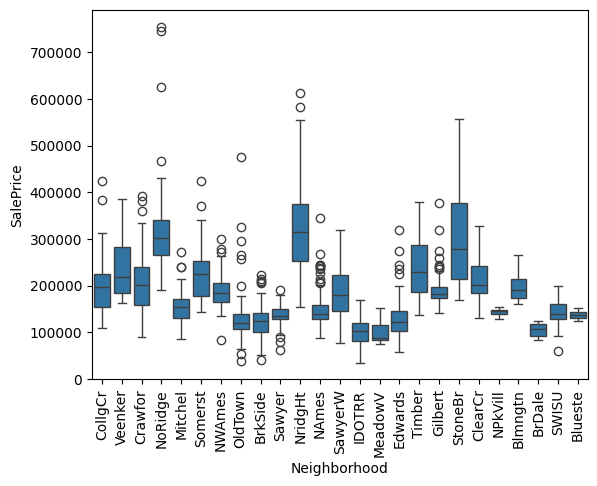

In [36]:
# Let's plot sale price versus Neighborhood

sns.boxplot(train, x=train.Neighborhood, y=train.SalePrice)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5, 6, 7, 8],
 [Text(0, 0, 'WD'),
  Text(1, 0, 'New'),
  Text(2, 0, 'COD'),
  Text(3, 0, 'ConLD'),
  Text(4, 0, 'ConLI'),
  Text(5, 0, 'CWD'),
  Text(6, 0, 'ConLw'),
  Text(7, 0, 'Con'),
  Text(8, 0, 'Oth')])

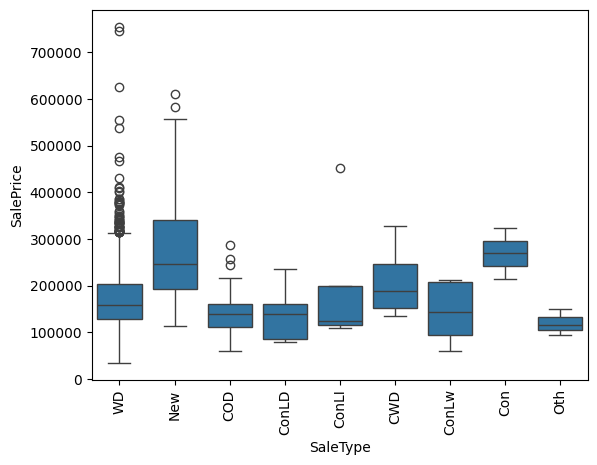

In [37]:
# Let's plot sale price versus SaleType

sns.boxplot(train, x=train.SaleType, y=train.SalePrice)
plt.xticks(rotation=90)

([0, 1, 2, 3, 4, 5],
 [Text(0, 0, 'Normal'),
  Text(1, 0, 'Abnorml'),
  Text(2, 0, 'Partial'),
  Text(3, 0, 'AdjLand'),
  Text(4, 0, 'Alloca'),
  Text(5, 0, 'Family')])

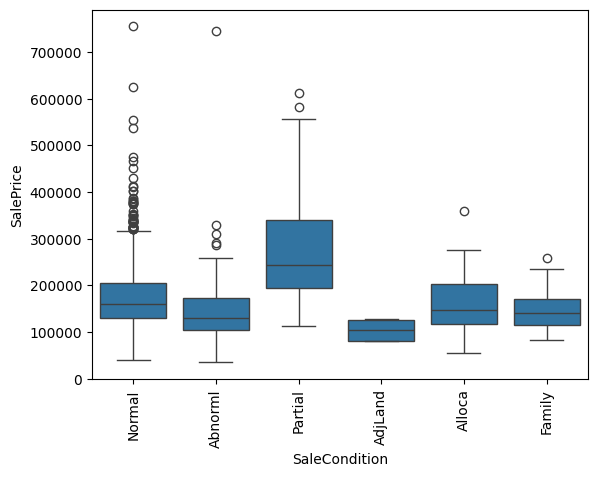

In [38]:
# Let's plot sale price versus SaleCondition

sns.boxplot(train, x=train.SaleCondition, y=train.SalePrice)
plt.xticks(rotation=90)

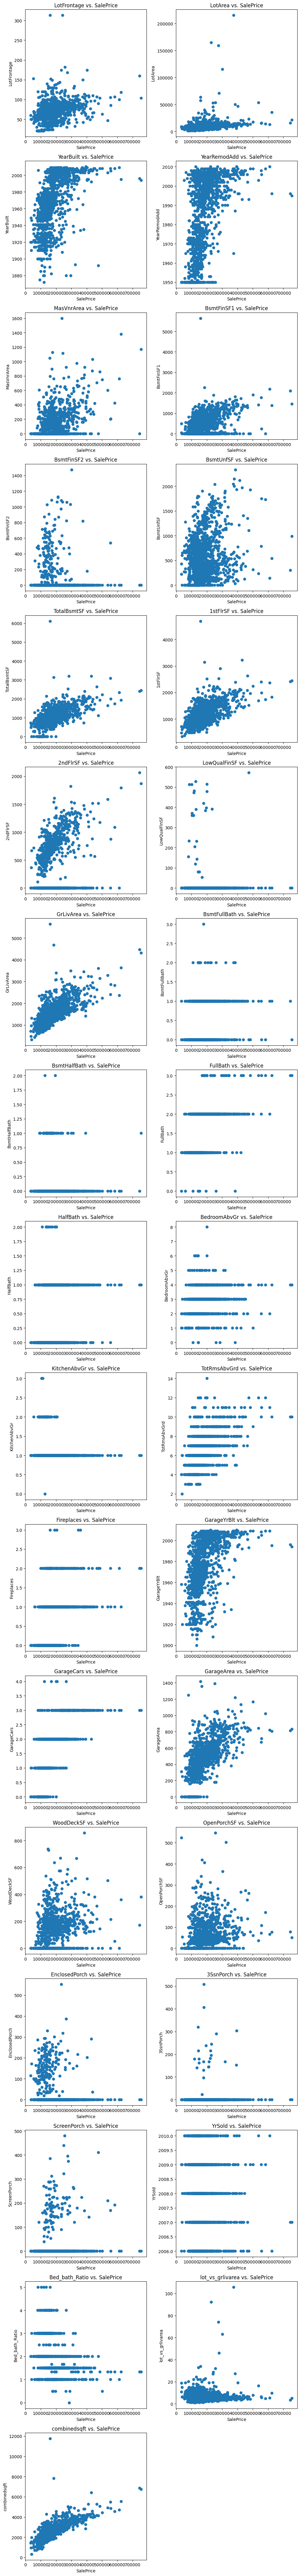

In [39]:
# Assuming 'df' is your DataFrame and 'target_column' is the name of the column you want to plot against.
target_column = 'SalePrice'

# List of columns to plot against the target_column. Excludes the target_column itself.
columns_to_plot = [col for col in train.columns.drop(['Id','MSSubClass', 'MSZoning', 'Street', 'LotShape',
               'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
               'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
               'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle',
               'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
               'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
               'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
               'Heating', 'HeatingQC', 'CentralAir', 'Electrical',
               'KitchenQual','Functional', 'FireplaceQu', 'GarageType',
               'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive',
               'MoSold','SaleType', 'SaleCondition']) if col != target_column]

# Determine the number of rows/columns for the subplot grid.
# Here, we're arranging plots in 2 columns. Adjust nrows and ncols as needed.
nrows = (len(columns_to_plot) + 1) // 2
ncols = 2

# Create a figure and a grid of subplots
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10, 5 * nrows))

# Flatten the array of axes (subplots) for easy iterating
axs = axs.flatten()

for i, col in enumerate(columns_to_plot):
    # Plot column vs. target_column in each subplot
    axs[i].scatter(train[target_column], train[col])
    axs[i].set_title(f'{col} vs. {target_column}')
    axs[i].set_xlabel(target_column)
    axs[i].set_ylabel(col)

# Hide any unused subplots
for ax in axs[len(columns_to_plot):]:
    ax.set_visible(False)

plt.tight_layout()
plt.show()

In [40]:
train.isna().sum().sort_values(ascending=False)

MasVnrType          872
FireplaceQu         690
LotFrontage         259
GarageYrBlt          81
GarageType           81
GarageFinish         81
GarageQual           81
GarageCond           81
BsmtExposure         38
BsmtFinType2         38
BsmtQual             37
BsmtCond             37
BsmtFinType1         37
MasVnrArea            8
Bed_bath_Ratio        5
Electrical            1
Fireplaces            0
KitchenQual           0
KitchenAbvGr          0
BedroomAbvGr          0
HalfBath              0
FullBath              0
TotRmsAbvGrd          0
BsmtHalfBath          0
Functional            0
BsmtFullBath          0
Id                    0
LowQualFinSF          0
GarageCars            0
GarageArea            0
PavedDrive            0
WoodDeckSF            0
OpenPorchSF           0
EnclosedPorch         0
3SsnPorch             0
ScreenPorch           0
MoSold                0
YrSold                0
SaleType              0
SaleCondition         0
SalePrice             0
lot_vs_grlivarea

*   Fill in Electrical of nan with mode (SBrkr)
*   Fill in Bed_bath_Ratio of nan with 0
*   Fill in Bed_bath_Ratio of inf with 0
*   Fill in MasVnrArea of nan with 0
*   Fill in MasVnrType of nan with None
*   Fill in BsmtQual of nan with NA
*   Fill in BsmtCond of nan with NA
*   Fill in BsmtFinType1 of nan with NA
*   Fill in BsmtFinType2 of nan with NA
*   Fill in BsmtExposure of nan with NA
*   Fill in GarageQual of nan with NA
*   Fill in GarageCond of nan with NA
*   Fill in GarageFinish of nan with NA
*   Fill in GarageYrBlt of nan with NA
*   Fill in GarageType of nan with NA
*   Fill in LotFrontage of nan with the median
*   Fill in FireplaceQu of nan with NA

In [41]:
to_na = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure',
         'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt',
         'GarageType', 'FireplaceQu']
to_zero = ['Bed_bath_Ratio', 'MasVnrArea']
to_none = ['MasVnrType']
to_median = ['LotFrontage']
to_mode = ['Electrical']

for col in to_na:
  train[col].fillna('NA', inplace=True)

for col in to_zero:
  train[col].fillna(0, inplace=True)

for col in to_none:
  train[col].fillna('None', inplace=True)

median_lotFrontage = train.LotFrontage.median()
for col in to_median:
  train[col].fillna(median_lotFrontage, inplace=True)

mode_Electrical = 'SBrkr'
for col in to_mode:
  train[col].fillna(mode_Electrical, inplace=True)

train.Bed_bath_Ratio = train.Bed_bath_Ratio.replace([np.nan, np.inf], 0)

In [42]:
# Now we'll do the same for test data but with a few more addtional columns

to_na = ['BsmtQual', 'BsmtCond', 'BsmtFinType1', 'BsmtFinType2', 'BsmtExposure',
         'GarageQual', 'GarageCond', 'GarageFinish', 'GarageYrBlt',
         'GarageType', 'FireplaceQu']
to_zero = ['Bed_bath_Ratio', 'MasVnrArea', 'BsmtFullBath', 'BsmtHalfBath',
           'combinedsqft', 'GarageCars', 'GarageArea', 'BsmtFinSF1',
           'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
to_none = ['MasVnrType']
to_median = ['LotFrontage']

for col in to_na:
  test[col].fillna('NA', inplace=True)

for col in to_zero:
  test[col].fillna(0, inplace=True)

for col in to_none:
  test[col].fillna('None', inplace=True)

median_lotFrontage = test.LotFrontage.median()
for col in to_median:
  test[col].fillna(median_lotFrontage, inplace=True)

mode_Electrical = 'SBrkr'
test['Electrical'].fillna(mode_Electrical, inplace=True)

mode_MSZoning = 'RL'
test['MSZoning'].fillna(mode_MSZoning, inplace=True)

mode_Functional = 'Typ'
test['Functional'].fillna(mode_Functional, inplace=True)

mode_Utilities = 'AllPub'
test['Utilities'].fillna(mode_Utilities, inplace=True)

mode_KitchenQual = 'TA'
test['KitchenQual'].fillna(mode_KitchenQual, inplace=True)

mode_Exterior1st = 'VinylSd'
test['Exterior1st'].fillna(mode_Exterior1st, inplace=True)

mode_SaleType = 'WD'
test['SaleType'].fillna(mode_SaleType, inplace=True)

mode_Exterior2nd = 'VinylSd'
test['Exterior2nd'].fillna(mode_Exterior2nd, inplace=True)

test.Bed_bath_Ratio = test.Bed_bath_Ratio.replace([np.nan, np.inf], 0)

In [43]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 78 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1460 non-null   int64  
 1   MSSubClass        1460 non-null   int64  
 2   MSZoning          1460 non-null   object 
 3   LotFrontage       1460 non-null   float64
 4   LotArea           1460 non-null   int64  
 5   Street            1460 non-null   object 
 6   LotShape          1460 non-null   object 
 7   LandContour       1460 non-null   object 
 8   Utilities         1460 non-null   object 
 9   LotConfig         1460 non-null   object 
 10  LandSlope         1460 non-null   object 
 11  Neighborhood      1460 non-null   object 
 12  Condition1        1460 non-null   object 
 13  Condition2        1460 non-null   object 
 14  BldgType          1460 non-null   object 
 15  HouseStyle        1460 non-null   object 
 16  OverallQual       1460 non-null   int64  


In [44]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 77 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1459 non-null   int64  
 1   MSSubClass        1459 non-null   int64  
 2   MSZoning          1459 non-null   object 
 3   LotFrontage       1459 non-null   float64
 4   LotArea           1459 non-null   int64  
 5   Street            1459 non-null   object 
 6   LotShape          1459 non-null   object 
 7   LandContour       1459 non-null   object 
 8   Utilities         1459 non-null   object 
 9   LotConfig         1459 non-null   object 
 10  LandSlope         1459 non-null   object 
 11  Neighborhood      1459 non-null   object 
 12  Condition1        1459 non-null   object 
 13  Condition2        1459 non-null   object 
 14  BldgType          1459 non-null   object 
 15  HouseStyle        1459 non-null   object 
 16  OverallQual       1459 non-null   int64  


In [45]:
# Recode columns for train data

ordinal_columns = [
     'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
     'YearRemodAdd', 'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond',
     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
     'FireplaceQu', 'GarageQual', 'GarageCond', 'MoSold', 'YrSold'
     ]

# Recode ordinal string columns to numerical
train['LotShape'].replace({'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, inplace=True)
train['LandSlope'].replace({'Gtl': 1, 'Mod': 2, 'Sev': 3}, inplace=True)
train['ExterQual'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}, inplace=True)
train['ExterCond'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}, inplace=True)
train['BsmtQual'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)
train['BsmtCond'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)
train['BsmtExposure'].replace({'Gd': 1, 'Av': 2, 'Mn': 3, 'No': 4, 'NA': 5}, inplace=True)
train['BsmtFinType1'].replace({'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'Unf': 6, 'NA': 7}, inplace=True)
train['BsmtFinType2'].replace({'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'Unf': 6, 'NA': 7}, inplace=True)
train['HeatingQC'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}, inplace=True)
train['KitchenQual'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}, inplace=True)
train['FireplaceQu'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)
train['GarageQual'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)
train['GarageCond'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)

# Let's encode categorical columns
categorical_columns = [
       'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces',  'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'PavedDrive',  'SaleType', 'SaleCondition',
       'Bed_bath_Ratio'
       ]

# Instantiate the encoder
encoder = TargetEncoder(cols=categorical_columns)

# Fit and transform the training data
X_train_encoded = encoder.fit_transform(train.drop(['Id','SalePrice'],axis=1), train.SalePrice)
y_train = train.SalePrice

In [46]:
# Recode columns for test data

ordinal_columns = [
     'LotShape', 'LandSlope', 'OverallQual', 'OverallCond', 'YearBuilt',
     'YearRemodAdd', 'ExterQual', 'ExterCond','BsmtQual', 'BsmtCond',
     'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'HeatingQC', 'KitchenQual',
     'FireplaceQu', 'GarageQual', 'GarageCond', 'MoSold', 'YrSold'
     ]

# Recode ordinal string columns to numerical
test['LotShape'].replace({'Reg': 1, 'IR1': 2, 'IR2': 3, 'IR3': 4}, inplace=True)
test['LandSlope'].replace({'Gtl': 1, 'Mod': 2, 'Sev': 3}, inplace=True)
test['ExterQual'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}, inplace=True)
test['ExterCond'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}, inplace=True)
test['BsmtQual'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)
test['BsmtCond'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)
test['BsmtExposure'].replace({'Gd': 1, 'Av': 2, 'Mn': 3, 'No': 4, 'NA': 5}, inplace=True)
test['BsmtFinType1'].replace({'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'Unf': 6, 'NA': 7}, inplace=True)
test['BsmtFinType2'].replace({'GLQ': 1, 'ALQ': 2, 'BLQ': 3, 'Rec': 4, 'LwQ': 5, 'Unf': 6, 'NA': 7}, inplace=True)
test['HeatingQC'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}, inplace=True)
test['KitchenQual'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5}, inplace=True)
test['FireplaceQu'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)
test['GarageQual'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)
test['GarageCond'].replace({'Ex': 1, 'Gd': 2, 'TA': 3, 'Fa': 4, 'Po': 5, 'NA': 6}, inplace=True)

# Let's encode categorical columns
categorical_columns = [
       'MSZoning', 'Street', 'LandContour', 'Utilities', 'LotConfig',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'Foundation', 'Heating', 'CentralAir', 'Electrical', 'BsmtFullBath',
       'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces',  'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'PavedDrive',  'SaleType', 'SaleCondition',
       'Bed_bath_Ratio'
       ]

# Transform the test data
X_test_encoded = encoder.transform(test.drop(['Id'],axis=1))

In [47]:
# Split and Scale data
#Create Training and test set for modelling
X_train, X_test, y_train, y_test = train_test_split(X_train_encoded, y_train,
                                                    test_size=0.20,
                                                    random_state=314)

# define a scaler
names = X_train.columns
X_scaler = StandardScaler()
X_train_scaled = pd.DataFrame(X_scaler.fit_transform(X_train), columns=names)
X_test_scaled = pd.DataFrame(X_scaler.transform(X_test), columns=names)
X_sub_test_scaled = pd.DataFrame(X_scaler.transform(X_test_encoded), columns=names)

# Log Target
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

In [ ]:
# Let's try CatBoost

def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 4, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'random_strength': trial.suggest_int('random_strength', 0, 100),
        'bagging_temperature': trial.suggest_loguniform('bagging_temperature', 0.01, 100.00),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10.0),
        'loss_function': 'RMSE',
    }
    model = CatBoostRegressor(**params, verbose=0, random_state=314)
    model.fit(X_train_scaled, y_train)
    preds = model.predict(X_test_scaled)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=100)

best_rmse = study.best_trial.value
print(f"Best RMSE: {best_rmse:.4f}")
print('Best trial parameters:', study.best_trial.params)

[I 2024-03-10 13:00:00,050] A new study created in memory with name: no-name-9a73d895-6132-4ef7-9130-0f57ecc0b165
[I 2024-03-10 13:00:00,370] Trial 0 finished with value: 0.12955110984211204 and parameters: {'iterations': 209, 'depth': 4, 'learning_rate': 0.04559092725504464, 'random_strength': 40, 'bagging_temperature': 0.02576626507556056, 'border_count': 116, 'l2_leaf_reg': 1.8121019609308846}. Best is trial 0 with value: 0.12955110984211204.
[I 2024-03-10 13:00:00,536] Trial 1 finished with value: 0.1376721443072926 and parameters: {'iterations': 209, 'depth': 4, 'learning_rate': 0.03845700700332287, 'random_strength': 100, 'bagging_temperature': 5.40995377081313, 'border_count': 172, 'l2_leaf_reg': 0.28696990422267526}. Best is trial 0 with value: 0.12955110984211204.
[I 2024-03-10 13:00:01,711] Trial 2 finished with value: 0.13599971987802373 and parameters: {'iterations': 914, 'depth': 9, 'learning_rate': 0.15835502354050723, 'random_strength': 80, 'bagging_temperature': 0.04216

In [ ]:
# Retrieve the best parameters
best_params = study.best_trial.params

# Specify 'loss_function'
if 'loss_function' not in best_params:
    best_params['loss_function'] = 'RMSE'

# Create a new model instance with the best parameters
model = CatBoostRegressor(**best_params, verbose=0, random_state=314)

# Fit the model on the training data
model.fit(X_train_scaled, y_train)

# Make predictions on the test data
predictions = model.predict(X_sub_test_scaled)

print(predictions)

In [ ]:
# Make submission dataframe
test_data = test.Id + X_sub_test_scaled
submission_df = pd.DataFrame({"Id": test_data["Id"], "SalePrice": predictions})

In [ ]:
# Export dataframe to csv
submission_df.to_csv("submission.csv", index=False)